In [1]:
import numpy as np
import pandas as pd
import math as mt
import scipy
import scipy.optimize as opt
import scipy.stats as sta
import matplotlib.pyplot as plt
import csv

import vector
from tqdm import tqdm

import pylorentz

In [2]:
plt.style.use('_mpl-gallery-nogrid')

#plt.style.use('mystyle.mplstyle')

palette_balanced = [
    "#3C38A0",  # deep indigo
#    "#7152B8",  # royal purple (new)
    "#1B7A6E",  # lighter teal
    "#3A2C20",  # cool dark brown
    "#C26824",  # bright burnt orange
    "#7A014A",  # wine magenta
]

plt.rcParams["axes.prop_cycle"] = plt.cycler(color=palette_balanced)

plt.rcParams["font.family"] = "serif"
plt.rcParams["mathtext.fontset"] = "dejavuserif"

#plt.bar(0, 1, color = 'C0')
#plt.bar(1, 1, color = 'C1')
#plt.bar(2, 1, color = 'C2')
#plt.bar(3, 1, color = 'C3')
#plt.bar(4, 1, color = 'C4')

In [3]:
from scipy import stats

def get_asymmetrical_uncertainties(hist: np.array,) -> tuple[np.array, np.array]:
    
    alpha = 1.0 - 0.682689492
    tail_probability = alpha / 2

    n = hist

    lower_bound = np.zeros_like(n, dtype=float)
    upper_bound = np.zeros_like(n, dtype=float)

    # Two-sided Garwood intervals for n > 0
    lower_bound[n > 0] = stats.gamma.ppf(q=tail_probability, a=n[n > 0], scale=1)
    upper_bound[n > 0] = stats.gamma.ppf(
        q=1 - tail_probability, a=n[n > 0] + 1, scale=1
    )

    # Compute asymmetric uncertainties
    uncertainties_low = n - lower_bound
    uncertainties_high = upper_bound - n

    uncertainties_low = np.nan_to_num(uncertainties_low, nan=0.0)
    uncertainties_high = np.nan_to_num(uncertainties_high, nan=0.0)

    return uncertainties_low, uncertainties_high


In [4]:
## some scale factors and constant you might use

## mass square of muon: m_muon^2 (in GeV)
sqm1 = (0.105658) * (0.105658)
## mass square of electron: m_e^2 (in GeV)
sqme = (0.0005109989) * (0.0005109989)
## mass of Z boson (in GeV)
mZ = 91.1876


## constants for the scale factor of MC. The MC is produced at a certain cross section\
## with certain number of events. To increase statistics, the event numbers generated are usually very large,\
## therefore a scale factor is needed to apply on the MC to make them agree with data.
## Scale factor for each MC component is: lumi * xsec / nevt, as provided below

## Luminosity of each year
lumi12 = 11580.
lumi11 = 2330.

## MC cross section of each process
xsecZZ412 = 0.107
xsecZZ2mu2e12 = 0.249
xsecZZ411 = 0.093
xsecZZ2mu2e11 = 0.208

xsecTTBar12 = 200.
xsecTTBar11 = 19.504

xsecDY5012 = 2955.
xsecDY1012 = 10.742
xsecDY5011 = 2475.
xsecDY1011 = 9507.
  
scalexsecHZZ12 = 0.0065
scalexsecHZZ11 = 0.0057

## Number of MC Events generated for each process
nevtZZ4mu12 = 1499064
nevtZZ4e12 = 1499093
nevtZZ2mu2e12 = 1497445
nevtHZZ12 = 299973 
nevtTTBar12 = 6423106
nevtDY5012 = 29426492
nevtDY1012 = 6462290
  
nevtZZ4mu11 = 1447136
nevtZZ4e11 = 1493308
nevtZZ2mu2e11 = 1479879
nevtHZZ11 = 299683
nevtTTBar11 = 9771205
nevtDY5011 = 36408225
nevtDY1011 = 39909640


labels = [r'$m_{H} = 125$ GeV', r'$ZZ \rightarrow 4l$', r'$Z/\gamma^{*} + X$', r'$t\bar{t}$']
colors = ['r','b','g','gray']
scales_higgs = [lumi11*scalexsecHZZ11/nevtHZZ11, lumi12*scalexsecHZZ12/nevtHZZ12]
scales_zz = [lumi11*xsecZZ411/nevtZZ4mu11, lumi11*xsecZZ2mu2e11/nevtZZ2mu2e11, lumi11*xsecZZ411/nevtZZ4e11,\
             lumi12*xsecZZ412/nevtZZ4mu12, lumi12*xsecZZ2mu2e12/nevtZZ2mu2e12, lumi12*xsecZZ412/nevtZZ4e12]
scales_dy = [lumi11*xsecDY1011/nevtDY1011, lumi11*xsecDY5011/nevtDY5011, \
             lumi12*xsecDY1012/nevtDY1012, lumi11*xsecDY5012/nevtDY5012]
scales_tt = [lumi11*xsecTTBar11/nevtTTBar11, lumi12*xsecTTBar12/nevtTTBar12]

In [5]:
### open the files ###
# read datalist of each year and combine to one 
data_year  = [pd.read_csv('data/clean_data_2011.csv',index_col=None, header=0)]
data_year += [pd.read_csv('data/clean_data_2012.csv',index_col=None, header=0)]
data = pd.concat(data_year,axis=0,ignore_index=True)


# read MClist of each process and each year
mc_higgs_11 = pd.read_csv('MC/higgs2011.csv',index_col=None, header=0)
mc_higgs_12 = pd.read_csv('MC/higgs2012.csv',index_col=None, header=0)
## ZZ*
mc_zz4mu_11 = pd.read_csv('MC/zzto4mu2011.csv',index_col=None, header=0)
mc_zz2mu2e_11 = pd.read_csv('MC/zzto2mu2e2011.csv',index_col=None, header=0)
mc_zz4e_11 = pd.read_csv('MC/zzto4e2011.csv',index_col=None, header=0)

mc_zz4mu_12 = pd.read_csv('MC/zzto4mu2012.csv',index_col=None, header=0)
mc_zz2mu2e_12 = pd.read_csv('MC/zzto2mu2e2012.csv',index_col=None, header=0)
mc_zz4e_12 = pd.read_csv('MC/zzto4e2012.csv',index_col=None, header=0)
## Drell-Yan
mc_dy10_11 = pd.read_csv('MC/dy1050_2011.csv',index_col=None, header=0)
mc_dy50_11 = pd.read_csv('MC/dy50_2011.csv',index_col=None, header=0)
mc_dy10_12 = pd.read_csv('MC/dy1050_2012.csv',index_col=None, header=0)
mc_dy50_12 = pd.read_csv('MC/dy50_2012.csv',index_col=None, header=0)
## ttbar
mc_ttbar_11 = pd.read_csv('MC/ttbar2011.csv',index_col=None, header=0)
mc_ttbar_12 = pd.read_csv('MC/ttbar2012.csv',index_col=None, header=0)


mc_list = [mc_higgs_11, mc_higgs_12, 
           mc_zz4mu_11, mc_zz2mu2e_11, mc_zz4e_11, mc_zz4mu_12, mc_zz2mu2e_12, mc_zz4e_12, 
           mc_dy10_11, mc_dy50_11, mc_dy10_12, mc_dy50_12,
           mc_ttbar_11, mc_ttbar_12]

In [6]:
# --- Utility functions ---
def pt(px, py):
    return np.sqrt(px**2 + py**2)

def delta_phi(phi1, phi2):
    dphi = phi1 - phi2
    return (dphi + np.pi) % (2*np.pi) - np.pi

def delta_r(eta1, phi1, eta2, phi2):
    return np.sqrt((eta1 - eta2)**2 + delta_phi(phi1, phi2)**2)

def delta_R(df, i, j):
    dphi = (df[f'phi{i}'] - df[f'phi{j}'] + np.pi) % (2 * np.pi) - np.pi
    deta = df[f'eta{i}'] - df[f'eta{j}']
    return np.sqrt(deta**2 + dphi**2)

In [7]:
def identify_event(df):
    """Vectorized reconstruction of Z candidates for 4-lepton events."""
    
    def inv_mass(E1, px1, py1, pz1, E2, px2, py2, pz2):
        return np.sqrt(np.maximum(0, (E1 + E2)**2 - ((px1 + px2)**2 + (py1 + py2)**2 + (pz1 + pz2)**2)))
    
    pid1 = df["PID1"] 
    pid2 = df["PID2"] 
    pid3 = df["PID3"] 
    pid4 = df["PID4"] 

#    print(pid1, pid2, pid3, pid4)

    evt_type = np.zeros(df.shape[0])

    conserve = ((pid1+pid2+pid3+pid4) == 0) & ((df["Q1"]+df["Q2"]+df["Q3"]+df["Q4"]) == 0)

    mask_2mu2e = conserve & (np.abs(pid1)+np.abs(pid2)+np.abs(pid3)+np.abs(pid4) == 48)

    mask_4e = conserve & (np.abs(pid1) == 11) & (np.abs(pid2) == 11) & (np.abs(pid3) == 11) & (np.abs(pid4) == 11)
    
    mask_4mu = conserve & (np.abs(pid1) == 13) & (np.abs(pid2) == 13) & (np.abs(pid3) == 13) & (np.abs(pid4) == 13) 

    evt_type[mask_2mu2e] = 1
    evt_type[mask_4e] = 2
    evt_type[mask_4mu] = 3

#    print(evt_type)

    df['event_type'] = evt_type

    return df


In [8]:
data = identify_event(data)
for mc in mc_list:
    mc = identify_event(mc)

In [9]:
def compute_mz(df):
    """Vectorized reconstruction of Z candidates for 4-lepton events."""
    
    def inv_mass(E1, px1, py1, pz1, E2, px2, py2, pz2):
        return np.sqrt(np.maximum(0, (E1 + E2)**2 - ((px1 + px2)**2 + (py1 + py2)**2 + (pz1 + pz2)**2)))

    pid1 = df["PID1"] 
    pid2 = df["PID2"] 
    pid3 = df["PID3"] 
    pid4 = df["PID4"]
    
    mask12 = (pid1+pid2 == 0) & (pid3+pid4 == 0) 
    mask13 = (pid1+pid3 == 0) & (pid2+pid4 == 0) 
    mask14 = (pid1+pid4 == 0) & (pid2+pid3 == 0) 

    ## 12 -> compute c1
    df.loc[mask12, "mz1_c1"] = inv_mass(
        df.loc[mask12, "E1"], df.loc[mask12, "px1"], df.loc[mask12, "py1"], df.loc[mask12, "pz1"],
        df.loc[mask12, "E2"], df.loc[mask12, "px2"], df.loc[mask12, "py2"], df.loc[mask12, "pz2"]
    )
    
    df.loc[mask12, "mz2_c1"] = inv_mass(
        df.loc[mask12, "E3"], df.loc[mask12, "px3"], df.loc[mask12, "py3"], df.loc[mask12, "pz3"],
        df.loc[mask12, "E4"], df.loc[mask12, "px4"], df.loc[mask12, "py4"], df.loc[mask12, "pz4"]
    )

    ## 13 -> compute c2
    df.loc[mask13, "mz1_c2"] = inv_mass(
        df.loc[mask13, "E1"], df.loc[mask13, "px1"], df.loc[mask13, "py1"], df.loc[mask13, "pz1"],
        df.loc[mask13, "E3"], df.loc[mask13, "px3"], df.loc[mask13, "py3"], df.loc[mask13, "pz3"]
    )
    
    df.loc[mask13, "mz2_c2"] = inv_mass(
        df.loc[mask13, "E2"], df.loc[mask13, "px2"], df.loc[mask13, "py2"], df.loc[mask13, "pz2"],
        df.loc[mask13, "E4"], df.loc[mask13, "px4"], df.loc[mask13, "py4"], df.loc[mask13, "pz4"]
    )

    ## 14 -> compute c3
    df.loc[mask14, "mz1_c3"] = inv_mass(
        df.loc[mask14, "E1"], df.loc[mask14, "px1"], df.loc[mask14, "py1"], df.loc[mask14, "pz1"],
        df.loc[mask14, "E4"], df.loc[mask14, "px4"], df.loc[mask14, "py4"], df.loc[mask14, "pz4"]
    )
    
    df.loc[mask14, "mz2_c3"] = inv_mass(
        df.loc[mask14, "E2"], df.loc[mask14, "px2"], df.loc[mask14, "py2"], df.loc[mask14, "pz2"],
        df.loc[mask14, "E3"], df.loc[mask14, "px3"], df.loc[mask14, "py3"], df.loc[mask14, "pz3"]
    )

    return df

In [10]:
data = compute_mz(data)
for mc in mc_list:
    mc = compute_mz(mc)

In [11]:
# --- Object selection ---
def object_selection(df):
    # Compute per-particle pt values
    for i in range(1, 5):
        df[f'pt{i}'] = pt(df[f'px{i}'], df[f'py{i}'])

    # Boolean masks for each lepton
    mu_mask = lambda i: (df[f'PID{i}'].abs() == 13) & (df[f'pt{i}'] > 5) & (np.abs(df[f'eta{i}']) < 2.4)
    el_mask = lambda i: (df[f'PID{i}'].abs() == 11) & (df[f'pt{i}'] > 7) & (np.abs(df[f'eta{i}']) < 2.5)

    # Apply object selection across all 4 leptons
    df['PassObj'] = (
        (mu_mask(1) | el_mask(1)) &
        (mu_mask(2) | el_mask(2)) &
        (mu_mask(3) | el_mask(3)) &
        (mu_mask(4) | el_mask(4))
    )

    return df
# --- Event selection ---

def event_selection(df):

    # Charge + flavor conservation
    conserve = df['event_type'] != 0

    # Apply final event selection mask
    df['PassEvt'] = conserve & df['PassObj'] 

    return df

In [12]:
### Apply object selection and event selection to data and each MC process###

data = event_selection(object_selection(data))

for mc in mc_list:
    mc = event_selection(object_selection(mc))

# creat a combined list of MC to study the shape
mc_higgs = [mc_higgs_11, mc_higgs_12]
mc_zz = [mc_zz4mu_11, mc_zz2mu2e_11, mc_zz4e_11, mc_zz4mu_12, mc_zz2mu2e_12, mc_zz4e_12]
mc_dy = [mc_dy10_11, mc_dy50_11, mc_dy10_12, mc_dy50_12]
mc_tt = [mc_ttbar_11, mc_ttbar_12]

mc_sig = pd.concat(mc_higgs,axis=0,ignore_index=True)
mc_bkg_zz = pd.concat(mc_zz,axis=0,ignore_index=True)
mc_bkg_dy = pd.concat(mc_dy,axis=0,ignore_index=True)
mc_bkg_tt = pd.concat(mc_tt,axis=0,ignore_index=True)

## For Selections:
mc_all = [mc_higgs, mc_zz, mc_dy, mc_tt]

In [13]:
np.mean(data['event_type'])

np.float64(1.433553597650514)

In [14]:
data.keys()

Index(['Run', 'Event', 'PID1', 'Q1', 'E1', 'px1', 'py1', 'pz1', 'eta1', 'phi1',
       'PID2', 'Q2', 'E2', 'px2', 'py2', 'pz2', 'eta2', 'phi2', 'PID3', 'Q3',
       'E3', 'px3', 'py3', 'pz3', 'eta3', 'phi3', 'PID4', 'Q4', 'E4', 'px4',
       'py4', 'pz4', 'eta4', 'phi4', 'event_type', 'mz1_c1', 'mz2_c1',
       'mz1_c2', 'mz2_c2', 'mz1_c3', 'mz2_c3', 'pt1', 'pt2', 'pt3', 'pt4',
       'PassObj', 'PassEvt'],
      dtype='object')

In [15]:
def InvMass_4l(lists):   ### faster way to get the 4l-system invMass directly from the list, as you may repeately run it for the final plot###
    E_tot = lists['E1'] + lists['E2'] + lists['E3'] + lists['E4']
    px_tot = lists['px1'] + lists['px2'] + lists['px3'] + lists['px4']
    py_tot = lists['py1'] + lists['py2'] + lists['py3'] + lists['py4']
    pz_tot = lists['pz1'] + lists['pz2'] + lists['pz3'] + lists['pz4']
    return np.sqrt(E_tot**2 - (px_tot**2 + py_tot**2 + pz_tot**2))

def HistInvMass4l(lis, scales, rmin, rmax, nbins):
    hist_lis = []
    hist_uncert_lis = []
    for i,pro in enumerate(lis):
        invM = InvMass_4l(pro)
        hist, bins = np.histogram(invM, bins = nbins, range = (rmin,rmax))
        hist = hist * scales[i]
        hist_lis.append(hist)
    
    return sum(hist_lis)

In [16]:
def calculate_M4l(df):   ### faster way to get the 4l-system invMass directly from the list, as you may repeately run it for the final plot###
    E_tot = df['E1'] + df['E2'] + df['E3'] + df['E4']
    px_tot = df['px1'] + df['px2'] + df['px3'] + df['px4']
    py_tot = df['py1'] + df['py2'] + df['py3'] + df['py4']
    pz_tot = df['pz1'] + df['pz2'] + df['pz3'] + df['pz4']
    df['m4l'] = np.sqrt(E_tot**2 - (px_tot**2 + py_tot**2 + pz_tot**2))
    return df

In [17]:
data = calculate_M4l(data)

for mc in mc_list:
    mc = calculate_M4l(mc)

In [18]:
print(min(mc_higgs_11['pt1']))
print(min(mc_higgs_11['pt2']))
print(min(mc_higgs_11['pt3']))
print(min(mc_higgs_11['pt4']))

1.1289773409776656
1.0170247280008535
1.5852926314059372
1.0468372544712956


10.360999323791118
5.823734291346061
3.0019705195254667
1.0468372544712956


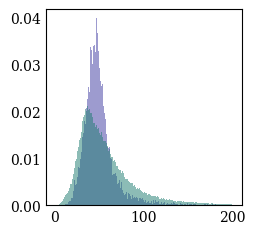

In [19]:
ptbins = np.linspace(0,200,200)
plt.hist(mc_sig.query("PID1 == 11")['pt1'], ptbins, alpha = 0.5, density = True, label = "sig")
plt.hist(mc_bkg_zz.query("PID1 == 11")['pt1'], ptbins, alpha = 0.5, density = True, label = "bkg")
#plt.hist(mc_bkg_dy['pt1'], ptbins, alpha = 0.5, density = True)
#plt.hist(mc_bkg_tt['pt1'], ptbins, alpha = 0.5, density = True)

plt.show

print(min(mc_sig.query("abs(PID1) == 11")['pt1']))
print(min(mc_sig.query("abs(PID2) == 11")['pt2']))
print(min(mc_sig.query("abs(PID3) == 11")['pt3']))
print(min(mc_sig.query("abs(PID4) == 11")['pt4']))

In [20]:
print(min(mc_sig.query("abs(PID1) == 13")['pt1']))
print(min(mc_sig.query("abs(PID2) == 13")['pt2']))
print(min(mc_sig.query("abs(PID3) == 13")['pt3']))
print(min(mc_sig.query("abs(PID4) == 13")['pt4']))

1.1289773409776656
1.0170247280008535
1.5852926314059372
1.0848942615757537


In [21]:
mc_zz = [mc_zz4mu_11, mc_zz2mu2e_11, mc_zz4e_11, mc_zz4mu_12, mc_zz2mu2e_12, mc_zz4e_12]
hist_zz = HistInvMass4l(mc_zz,scales_zz,rmin, rmax, nbins)

print(sum(hist_zz))

mc_zz = [mc_zz4mu_11.query("PassSel==True"), mc_zz2mu2e_11.query("PassSel==True"), mc_zz4e_11.query("PassSel==True"), mc_zz4mu_12.query("PassSel==True"), mc_zz2mu2e_12.query("PassSel==True"), mc_zz4e_12.query("PassSel==True")]
hist_zz = HistInvMass4l(mc_zz,scales_zz,rmin, rmax, nbins)

print(sum(hist_zz))

print(101.88/367.74)

NameError: name 'rmin' is not defined

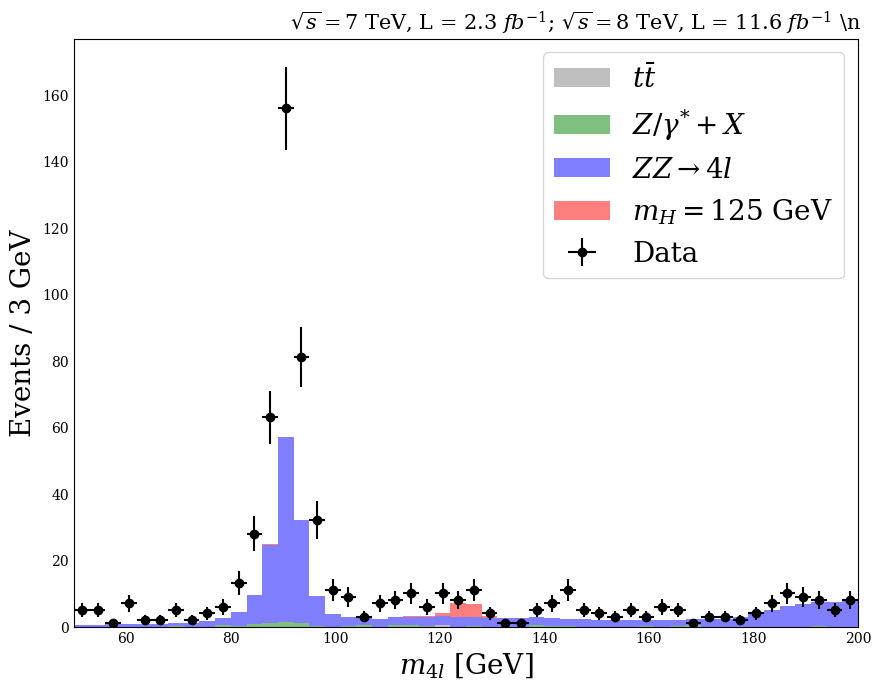

In [22]:
mc_higgs = [mc_higgs_11.query('PassEvt == True'), mc_higgs_12.query('PassEvt == True')]
mc_zz = [mc_zz4mu_11.query('PassEvt == True'), mc_zz2mu2e_11.query('PassEvt == True'), mc_zz4e_11.query('PassEvt == True'), mc_zz4mu_12.query('PassEvt == True'), mc_zz2mu2e_12.query('PassEvt == True'), mc_zz4e_12.query('PassEvt == True')]
mc_dy = [mc_dy10_11.query('PassEvt == True'), mc_dy50_11.query('PassEvt == True'), mc_dy10_12.query('PassEvt == True'), mc_dy50_12.query('PassEvt == True')]
mc_tt = [mc_ttbar_11.query('PassEvt == True'), mc_ttbar_12.query('PassEvt == True')]

rmin = 50
rmax = 200
nbins = 50

 
hist_higgs = HistInvMass4l(mc_higgs,scales_higgs,rmin, rmax, nbins)
hist_zz = HistInvMass4l(mc_zz,scales_zz,rmin, rmax, nbins)
hist_dy= HistInvMass4l(mc_dy,scales_dy,rmin, rmax, nbins)
hist_tt= HistInvMass4l(mc_tt,scales_tt,rmin, rmax, nbins)

hist_mc = [hist_tt, hist_dy, hist_zz, hist_higgs]

## Now Plot it!!!

plt.figure(figsize = (8,6))
#plt.style.use('mystyle.mplstyle')


## data
inM_data = InvMass_4l(data.query('PassEvt == True'))
hist, bins = np.histogram(inM_data, bins = nbins, range = (rmin,rmax))
binwidth = bins[1] - bins[0]
bincenter = 0.5 * (bins[:-1] + bins[1:])


## MC
for i,pro in enumerate(hist_mc):
    if i == 0:
        stack = plt.bar(bincenter, pro, align = 'center', width = binwidth, color = colors[3-i], label=labels[3-i],
                 alpha = 0.5)
        bot = pro
    else:
        stack = plt.bar(bincenter, pro, align = 'center', width = binwidth, color = colors[3-i], label=labels[3-i],
                 bottom = bot, alpha = 0.5)
        bot = bot + pro



## Measured data
xerrs = [binwidth*0.5 for i in range(0, nbins)]
yerrs = np.sqrt(hist)
marker_data = plt.errorbar(bincenter, hist, xerr = xerrs, yerr = yerrs, linestyle = 'None', color = 'black',
                        marker = 'o', label = 'Data')



plt.title(r'$ \sqrt{s} = 7$ TeV, L = 2.3 $fb^{-1}$; $\sqrt{s} = 8$ TeV, L = 11.6 $fb^{-1}$ \n', fontsize = 15, position=(0.64,0.95))
plt.xlabel(r'$m_{4l}$ [GeV]',fontsize = 20, position=(0.92,0.1))
plt.ylabel(r'Events / 3 GeV',fontsize = 20, position=(0.1,0.84))
plt.xlim(rmin,rmax)
plt.legend(fontsize = 20)

plt.show()

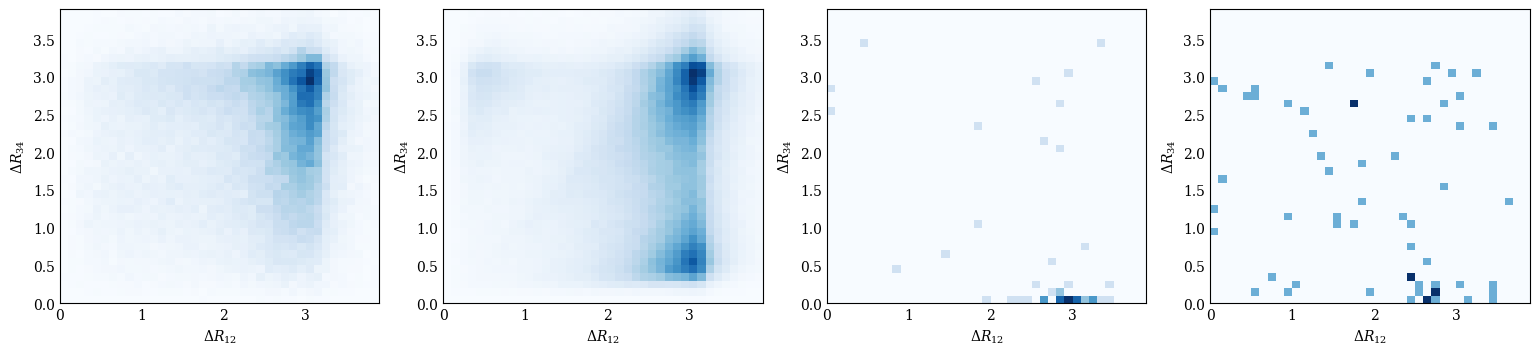

In [23]:
bins = (np.arange(0, 4, 0.1), np.arange(0, 4, 0.1))
#bins = None

fig, (ax0,ax1,ax2,ax3) = plt.subplots(1,4)
fig.set_figheight(3)
fig.set_figwidth(15)

ax0.hist2d(delta_R(mc_sig.query('PassEvt == True'), 1, 2), 
           delta_R(mc_sig.query('PassEvt == True'), 3, 4),
           bins, 
           density = True, label = labels[0])
ax0.set_xlabel(r"$\Delta R_{12}$")
ax0.set_ylabel(r"$\Delta R_{34}$")

ax1.hist2d(delta_R(mc_bkg_zz.query('PassEvt == True'), 1, 2), 
           delta_R(mc_bkg_zz.query('PassEvt == True'), 3, 4),
           bins, 
           density = True, label = labels[1])
ax1.set_xlabel(r"$\Delta R_{12}$")
ax1.set_ylabel(r"$\Delta R_{34}$")

ax2.hist2d(delta_R(mc_bkg_dy.query('PassEvt == True'), 1, 2), 
           delta_R(mc_bkg_dy.query('PassEvt == True'), 3, 4),
           bins, 
           density = True, label = labels[2])
ax2.set_xlabel(r"$\Delta R_{12}$")
ax2.set_ylabel(r"$\Delta R_{34}$")

ax3.hist2d(delta_R(mc_bkg_tt.query('PassEvt == True'), 1, 2), 
           delta_R(mc_bkg_tt.query('PassEvt == True'), 3, 4),
           bins, 
           density = True, label = labels[3])
ax3.set_xlabel(r"$\Delta R_{12}$")
ax3.set_ylabel(r"$\Delta R_{34}$")

#plt.legend()
plt.show()

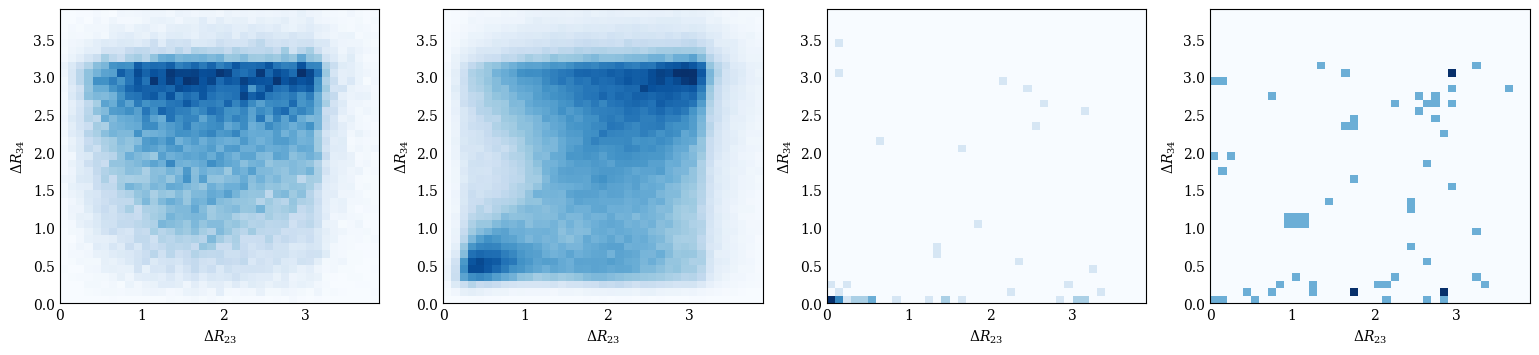

In [24]:
bins = (np.arange(0, 4, 0.1), np.arange(0, 4, 0.1))
#bins = None

fig, (ax0,ax1,ax2,ax3) = plt.subplots(1,4)
fig.set_figheight(3)
fig.set_figwidth(15)

ax0.hist2d(delta_R(mc_sig.query('PassEvt == True '), 3, 2), 
           delta_R(mc_sig.query('PassEvt == True '), 4, 3),
           bins, 
           density = True, label = labels[0])
ax0.set_xlabel(r"$\Delta R_{23}$")
ax0.set_ylabel(r"$\Delta R_{34}$")

ax1.hist2d(delta_R(mc_bkg_zz.query('PassEvt == True '), 3, 2), 
           delta_R(mc_bkg_zz.query('PassEvt == True '), 4, 3),
           bins, 
           density = True, label = labels[1])
ax1.set_xlabel(r"$\Delta R_{23}$")
ax1.set_ylabel(r"$\Delta R_{34}$")

ax2.hist2d(delta_R(mc_bkg_dy.query('PassEvt == True '), 3, 2), 
           delta_R(mc_bkg_dy.query('PassEvt == True '), 4, 3),
           bins, 
           density = True, label = labels[2])
ax2.set_xlabel(r"$\Delta R_{23}$")
ax2.set_ylabel(r"$\Delta R_{34}$")

ax3.hist2d(delta_R(mc_bkg_tt.query('PassEvt == True '), 3, 2), 
           delta_R(mc_bkg_tt.query('PassEvt == True '), 4, 3),
           bins, 
           density = True, label = labels[3])
ax3.set_xlabel(r"$\Delta R_{23}$")
ax3.set_ylabel(r"$\Delta R_{34}$")

#plt.legend
plt.show()

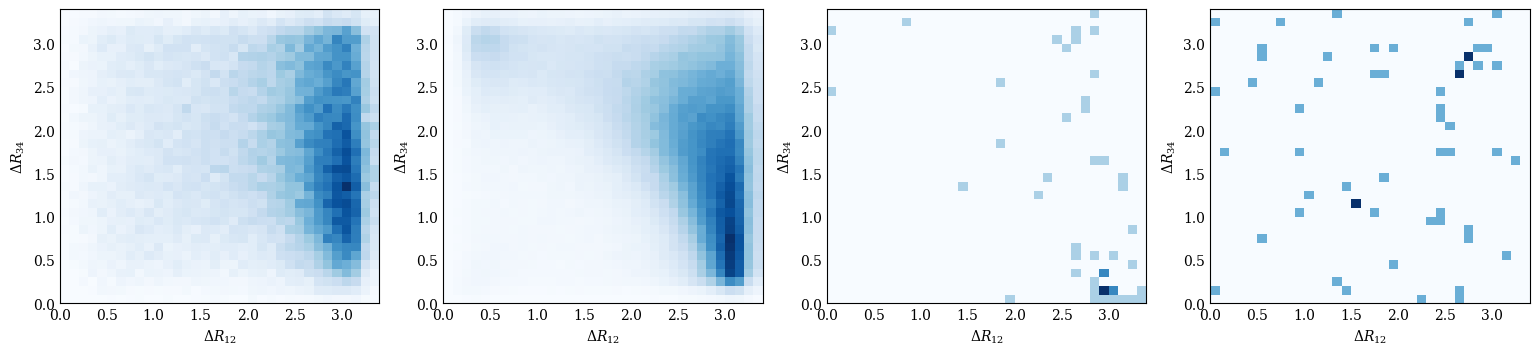

In [25]:
bins = (np.arange(0, 3.5, 0.1), np.arange(0, 3.5, 0.1))
#bins = None

fig, (ax0,ax1,ax2,ax3) = plt.subplots(1,4)
fig.set_figheight(3)
fig.set_figwidth(15)

ax0.hist2d(delta_R(mc_sig.query('PassEvt == True'), 1, 2), 
           delta_R(mc_sig.query('PassEvt == True'), 3, 2),
           bins, 
           density = True, label = labels[0])
ax0.set_xlabel(r"$\Delta R_{12}$")
ax0.set_ylabel(r"$\Delta R_{34}$")

ax1.hist2d(delta_R(mc_bkg_zz.query('PassEvt == True'), 1, 2), 
           delta_R(mc_bkg_zz.query('PassEvt == True'), 3, 2),
           bins, 
           density = True, label = labels[1])
ax1.set_xlabel(r"$\Delta R_{12}$")
ax1.set_ylabel(r"$\Delta R_{34}$")

ax2.hist2d(delta_R(mc_bkg_dy.query('PassEvt == True'), 1, 2), 
           delta_R(mc_bkg_dy.query('PassEvt == True'), 3, 2),
           bins, 
           density = True, label = labels[2])
ax2.set_xlabel(r"$\Delta R_{12}$")
ax2.set_ylabel(r"$\Delta R_{34}$")

ax3.hist2d(delta_R(mc_bkg_tt.query('PassEvt == True'), 1, 2), 
           delta_R(mc_bkg_tt.query('PassEvt == True'), 3, 2),
           bins, 
           density = True, label = labels[3])
ax3.set_xlabel(r"$\Delta R_{12}$")
ax3.set_ylabel(r"$\Delta R_{34}$")

#plt.legend()
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

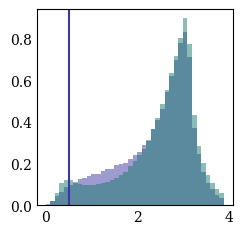

In [26]:
bins = np.arange(0, 4, 0.1)

plt.hist(delta_R(mc_sig.query('PassEvt == True'), 1, 2), bins, alpha = 0.5, density = True )
plt.hist(delta_R(mc_bkg_zz.query('PassEvt == True'), 1, 2), bins, alpha = 0.5, density = True )
plt.axvline(0.5)
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

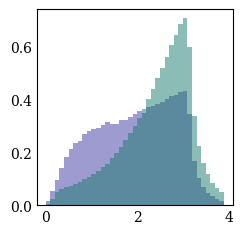

In [27]:
bins = np.arange(0, 4, 0.1)

plt.hist(delta_R(mc_sig.query('PassEvt == True'), 1, 3), bins, alpha = 0.5, density = True )
plt.hist(delta_R(mc_bkg_zz.query('PassEvt == True'), 1, 3), bins, alpha = 0.5, density = True )
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

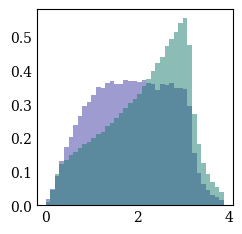

In [28]:
bins = np.arange(0, 4, 0.1)

plt.hist(delta_R(mc_sig.query('PassEvt == True'), 1, 4), bins, alpha = 0.5, density = True )
plt.hist(delta_R(mc_bkg_zz.query('PassEvt == True'), 1, 4), bins, alpha = 0.5, density = True )
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

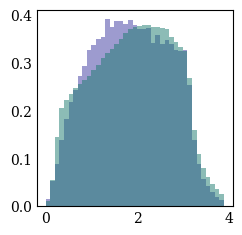

In [29]:
bins = np.arange(0, 4, 0.1)

plt.hist(delta_R(mc_sig.query('PassEvt == True'), 2, 3), bins, alpha = 0.5, density = True )
plt.hist(delta_R(mc_bkg_zz.query('PassEvt == True'), 2, 3), bins, alpha = 0.5, density = True )
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

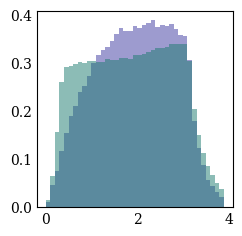

In [30]:
bins = np.arange(0, 4, 0.1)

plt.hist(delta_R(mc_sig.query('PassEvt == True'), 2, 4), bins, alpha = 0.5, density = True )
plt.hist(delta_R(mc_bkg_zz.query('PassEvt == True'), 2, 4), bins, alpha = 0.5, density = True )
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

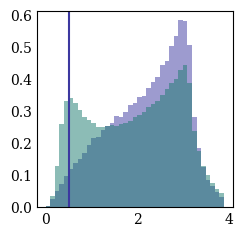

In [31]:
bins = np.arange(0, 4, 0.1)

plt.hist(delta_R(mc_sig.query('PassEvt == True'), 4, 3), bins, alpha = 0.5, density = True )
plt.hist(delta_R(mc_bkg_zz.query('PassEvt == True'), 4, 3), bins, alpha = 0.5, density = True )
plt.axvline(0.5)
plt.show

In [32]:
def apply_event_selection(df):

    # Charge + flavor conservation
    conserve = df['event_type'] != 0

    pid1 = df["PID1"] 
    pid2 = df["PID2"] 
    pid3 = df["PID3"] 
    pid4 = df["PID4"]
    
    mask12 = (pid1+pid2 == 0) & (pid3+pid4 == 0) 
    mask13 = (pid1+pid3 == 0) & (pid2+pid4 == 0) 
    mask14 = (pid1+pid4 == 0) & (pid2+pid3 == 0) 

    angular = (delta_R(df, 1, 2) > 0.15) & (delta_R(df, 3, 4)> 0.15) & (delta_R(df, 1, 3)> 0.15)  & (delta_R(df, 2, 4) > 0.15) & (delta_R(df, 1, 4) > 0.15) & (delta_R(df, 2, 3) > 0.15)

    Zmass1 =  mask12 & ( (df["mz1_c1"].between(20, 120) & df["mz2_c1"].between(40, 120)) | 
                         (df["mz2_c1"].between(20, 120) & df["mz1_c1"].between(40, 120)) )  

    Zmass2 =  mask13 & ( (df["mz1_c2"].between(20, 120) & df["mz2_c2"].between(40, 120)) | 
                         (df["mz2_c2"].between(20, 120) & df["mz1_c2"].between(40, 120)) ) 
    
    Zmass3 =  mask14 & ( (df["mz1_c3"].between(20, 120) & df["mz2_c3"].between(40, 120)) | 
                         (df["mz2_c3"].between(20, 120) & df["mz1_c3"].between(40, 120)) ) 

    Zmass = Zmass1 | Zmass2 | Zmass3


    # Apply final event selection mask
    df['PassSel'] = (conserve 
                     & df['PassObj'] 
                     & angular 
                     & Zmass
                    )  # you can extend with additional cuts if needed

    return df

### Apply object selection and event selection to data and each MC process###
data_obj_sel = object_selection(data)
data_evt_sel = apply_event_selection(data_obj_sel)

print('eff on data: ' , (data.query('PassSel == True').shape[0]/ data.shape[0]))

for i,bkg in enumerate(mc_all):
    for j,pro in enumerate(bkg):
        mc_all[i][j] = apply_event_selection(object_selection(pro))

print('eff on signal: ' , (scales_higgs[0]*mc_higgs_11.query('PassSel == True').shape[0]+ scales_higgs[1]*mc_higgs_12.query('PassSel == True').shape[0])/(scales_higgs[0]*mc_higgs_11.shape[0]+scales_higgs[1]*mc_higgs_12.shape[0]))

print('eff on signal: ' , (scales_higgs[0]*mc_higgs_11.query('PassSel == True').shape[0]+ scales_higgs[1]*mc_higgs_12.query('PassSel == True').shape[0])/(scales_higgs[0]*mc_higgs_11.shape[0]+scales_higgs[1]*mc_higgs_12.shape[0]))

eff on data:  0.092143906020558
eff on signal:  0.7250266243665606
eff on signal:  0.7250266243665606


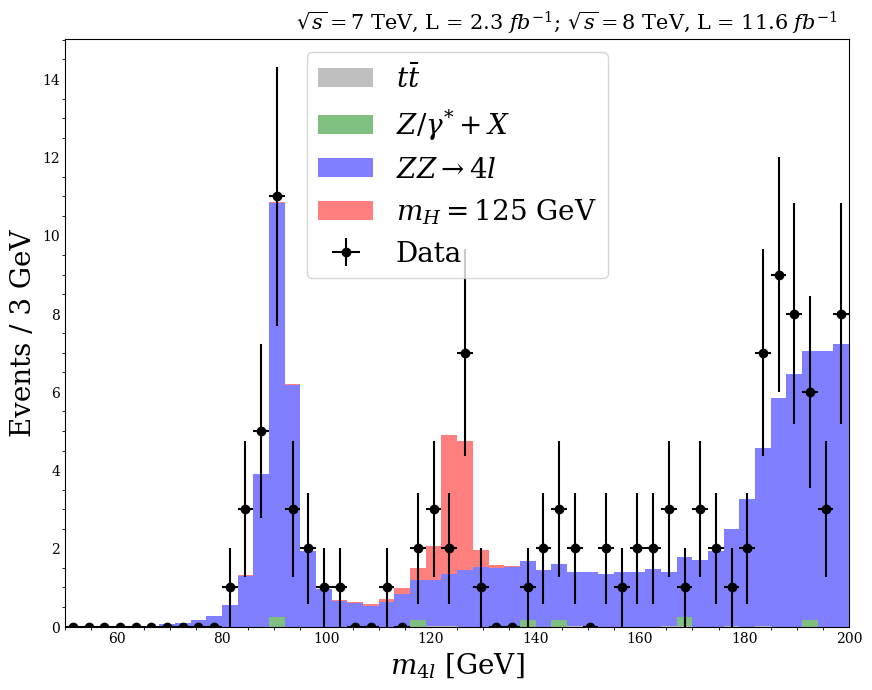

In [33]:
mc_higgs = [mc_higgs_11.query('PassSel == True'), mc_higgs_12.query('PassSel == True')]
mc_zz = [mc_zz4mu_11.query('PassSel == True'), mc_zz2mu2e_11.query('PassSel == True'), mc_zz4e_11.query('PassSel == True'), mc_zz4mu_12.query('PassSel == True'), mc_zz2mu2e_12.query('PassSel == True'), mc_zz4e_12.query('PassSel == True')]
mc_dy = [mc_dy10_11.query('PassSel == True'), mc_dy50_11.query('PassSel == True'), mc_dy10_12.query('PassSel == True'), mc_dy50_12.query('PassSel == True')]
mc_tt = [mc_ttbar_11.query('PassSel == True'), mc_ttbar_12.query('PassSel == True')]

rmin = 50
rmax = 200
nbins = 50

 
hist_higgs = HistInvMass4l(mc_higgs,scales_higgs,rmin, rmax, nbins)
hist_zz = HistInvMass4l(mc_zz,scales_zz,rmin, rmax, nbins)
hist_dy= HistInvMass4l(mc_dy,scales_dy,rmin, rmax, nbins)
hist_tt= HistInvMass4l(mc_tt,scales_tt,rmin, rmax, nbins)

hist_mc = [hist_tt, hist_dy, hist_zz, hist_higgs]

## Now Plot it!!!

plt.figure(figsize = (8,6))
#plt.style.use('mystyle.mplstyle')


## data
inM_data = InvMass_4l(data_evt_sel.query('PassSel == True'))
hist, bins = np.histogram(inM_data, bins = nbins, range = (rmin,rmax))
binwidth = bins[1] - bins[0]
bincenter = 0.5 * (bins[:-1] + bins[1:])


## MC
for i,pro in enumerate(hist_mc):
    if i == 0:
        stack = plt.bar(bincenter, pro, align = 'center', width = binwidth, color = colors[3-i], label=labels[3-i],
                 alpha = 0.5)
        bot = pro
    else:
        stack = plt.bar(bincenter, pro, align = 'center', width = binwidth, color = colors[3-i], label=labels[3-i],
                 bottom = bot, alpha = 0.5)
        bot = bot + pro



## Measured data
xerrs = [binwidth*0.5 for i in range(0, nbins)]
yerrs = np.sqrt(hist)
marker_data = plt.errorbar(bincenter, hist, xerr = xerrs, yerr = yerrs, linestyle = 'None', color = 'black',
                        marker = 'o', label = 'Data')



plt.title(r'$ \sqrt{s} = 7$ TeV, L = 2.3 $fb^{-1}$; $\sqrt{s} = 8$ TeV, L = 11.6 $fb^{-1}$', fontsize = 15, position=(0.64,0.95))
plt.xlabel(r'$m_{4l}$ [GeV]',fontsize = 20, position=(0.92,0.1))
plt.ylabel(r'Events / 3 GeV',fontsize = 20, position=(0.1,0.84))
plt.xlim(50,200)
plt.legend(fontsize = 20)
plt.minorticks_on()
plt.show()

In [34]:
def binned_LL(model, data, bincenter):
   
    signal_range = np.intersect1d(np.where(bincenter>110), 
                                  np.where(bincenter<160), 
                                  np.where(model>0))
    model = np.asarray(model[signal_range])
    data = np.asarray(data[signal_range]) 

    LL = data*np.log(model) - model - np.log(scipy.special.gamma(data+1))
    print(LL)
    return np.sum(LL) 

def binned_DeltaLL(model1, model2, data, bincenter):
   
    signal_range = np.intersect1d(np.where(bincenter<160), np.where(bincenter>110))
#    print(signal_range)
    model1 = np.asarray(model1[signal_range])
    model2 = np.asarray(model2[signal_range])
    data  = np.asarray(data[signal_range])

    # model must be positive
#    if np.any(model1 <= 0):
#        return np.inf

#    if np.any(model2 <= 0):
#        return np.inf

    DeltaLL = data*np.log(model1/model2) - (model1-model2)
    
    return np.sum(DeltaLL)

In [35]:
# display iminuit version
import iminuit

# everything in iminuit is done through the Minuit object, so we import it
from iminuit import minimize  # has same interface as scipy.optimize.minimize
from iminuit import Minuit, describe

In [36]:
def binned_NLL_side(model, data, bincenter):
   
    side_range = np.intersect1d( 
        np.union1d( np.where(bincenter<110), np.where(bincenter>160) ), 
        np.where(model>0)
    )
    
    model = np.asarray(model[side_range])
    data = np.asarray(data[side_range]) 

    LL = data*np.log(model) - model - np.log(scipy.special.gamma(data+1))
    
    return -np.sum(LL)
    
    
def NLL_side_minuit(b_scale):
    model = b_scale * (hist_mc[0]+hist_mc[1]+hist_mc[2])
    return binned_NLL_side(model, hist, bincenter)

In [37]:
m = Minuit(NLL_side_minuit, b_scale=1.0)   # initial guess
m.errordef = Minuit.LIKELIHOOD        # for NLL minimization

m.limits["b_scale"] = (0, None)       # optional: force positive scale

m.migrad()
m.minos()                            # run minimization

print(m.values["b_scale"])
print(m.errors["b_scale"])
m

1.0212990332605068
0.11272969908673591


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 40.51                      │              Nfcn = 17               │
│ EDM = 4.71e-06 (Goal: 0.0001)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬─────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name    │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼─────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ b_scale │   1.02    │   0.11    │   -0.11    │    0.12    │    0    │         │       │
└───┴─────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌──────────┬───────────────────────┐
│          │        b_scale        │
├──────────┼───────────┬───────────┤
│  Error   │   -0.11   │   0.12    │
│  Valid   │   True    │   True    │
│ At Limit │   False   │   False   │
│ Max FCN  │   False   │   False   │
│ New Min  │   False   │   False   │
└──────────┴───────────┴───────────┘
┌─────────┬─────────┐
│         │ b_scale │
├─────────┼─────────┤
│ b_scale │  0.0127 │
└─────────┴─────────┘

In [38]:
null_model = m.values['b_scale']*(hist_tt + hist_dy + hist_zz)

DLL = binned_NLL_side(null_model, null_model, bincenter) - binned_NLL_side(null_model, hist, bincenter)

print("expected significance:" , np.sqrt(-2*DLL))

expected significance: 3.6209545190416135


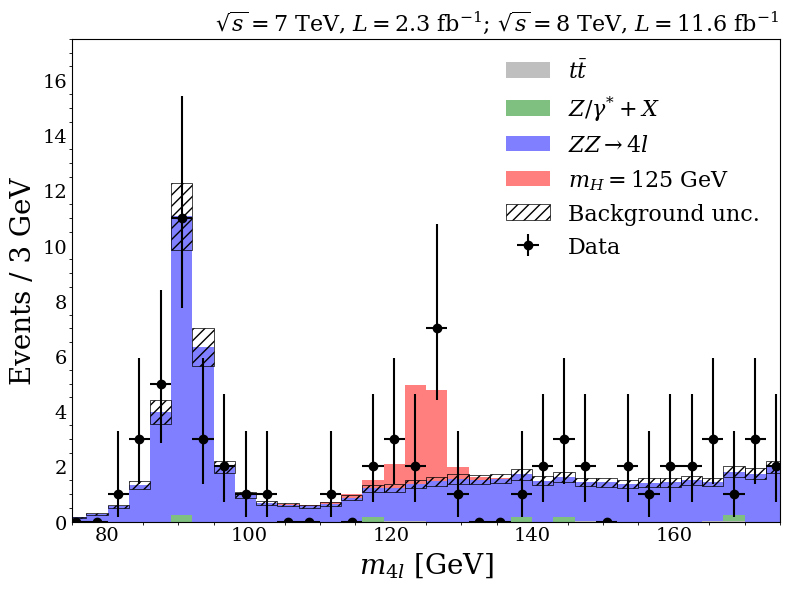

In [39]:
plt.figure(figsize=(8,6))

b_scale = m.values["b_scale"]
b_scale_err = m.errors["b_scale"]

# Raw background only (no signal)
bkg_raw = hist_tt + hist_dy + hist_zz
bkg = b_scale * bkg_raw
bkg_unc = b_scale_err * bkg_raw

############################
# Stacked MC (Higgs on top)
############################

# Make *copies* so original histograms are not modified
scaled_hist_tt = b_scale * hist_tt
scaled_hist_dy = b_scale * hist_dy
scaled_hist_zz = b_scale * hist_zz
scaled_hist_higgs = hist_higgs  # signal is *not* scaled

stack_list = [scaled_hist_tt, scaled_hist_dy, scaled_hist_zz, scaled_hist_higgs]


bot = np.zeros_like(bincenter)

for label, color, component in zip(labels[::-1], colors[::-1], stack_list):
    plt.bar(
        bincenter, component,
        align='center', width=binwidth,
        bottom=bot, color=color, alpha=0.5,
        label=label
    )
    bot = bot + component

############################
# Background uncertainty band
############################
# Bin width half
half_width = binwidth * 0.5

# Plot vertical uncertainty bars with hatching
plt.bar(
    bincenter,
    2 * bkg_unc,            # full height = ±unc
    bottom=bkg - bkg_unc,   # center the bar
    width=binwidth,
    fill=True,
    edgecolor="black",
    linewidth=0.5,
    hatch="///",            # striped/hatching style
    color="none",           # transparent, only hatch visible
    alpha=1,
    label="Background unc."
)

############################
# Plot data
############################
xerrs = np.full_like(bincenter, binwidth * 0.5)
yerrs = np.array(get_asymmetrical_uncertainties(hist))

plt.errorbar(
    bincenter, hist,
    xerr=xerrs, yerr=yerrs,
    fmt='o', color='black',
    label='Data'
)

############################
# Labels and formatting
############################
plt.title(r'$ \sqrt{s} = 7$ TeV, $L = 2.3$ fb$^{-1}$; $\sqrt{s} = 8$ TeV, $ L = 11.6$ fb$^{-1}$', 
          fontsize=16, position=(0.6,0.95))

plt.xlabel(r'$m_{4l}$ [GeV]', fontsize=20)
plt.ylabel(r'Events / 3 GeV', fontsize=20)
plt.xlim(75,175)
plt.ylim(0, 17.5)

plt.legend(fontsize=16, loc='upper right', frameon=False)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.minorticks_on()
plt.tight_layout()

plt.savefig("large_witherror.pdf")
plt.show()


In [40]:
null_model = m.values['b_scale']*(hist_tt + hist_dy + hist_zz)
higgs_model =  null_model + hist_higgs

DLL = binned_DeltaLL(null_model,  higgs_model, higgs_model, bincenter) 

print("expected significance:" , np.sqrt(-2*DLL))

expected significance: 3.306931935983425


In [48]:
print(sum(0.12*(hist_tt + hist_dy + hist_zz)[(bincenter>120) & (bincenter<130)]))

0.6571635300878271


In [897]:
null_model = m.values['b_scale']*(hist_tt + hist_dy + hist_zz)
higgs_model =  null_model + hist_higgs
DLL = binned_DeltaLL(null_model,  higgs_model, hist, bincenter) 
print("observed significance:" , np.sqrt(-2*DLL))

observed significance: 2.9742082573946407


In [898]:
def binned_NLL_center(model, data, bincenter):
   
    side_range = np.intersect1d( 
        np.union1d( np.where(bincenter<160), np.where(bincenter>110) ), 
        np.where(model>0)
    )
    
    model = np.asarray(model[side_range])
    data = np.asarray(data[side_range]) 

    LL = data*np.log(model) - model - np.log(scipy.special.gamma(data+1))
    
    return -np.sum(LL)
    
    
def NLL_center_minuit(s_scale):
    model = b_scale * (hist_mc[0]+hist_mc[1]+hist_mc[2]) + s_scale*hist_mc[3]
    return binned_NLL_center(model, hist, bincenter)

In [899]:
m_center = Minuit(NLL_center_minuit, s_scale=0.7)   # initial guess
m_center.errordef = Minuit.LIKELIHOOD        # for NLL minimization

m_center.limits["s_scale"] = (0.3, 2.0)       # optional: force positive scale

m_center.migrad()                            # run minimization
m_center.minos()
print(m_center.values["s_scale"])
print(m_center.errors["s_scale"])
m_center.values

0.8881520005412548
0.3937631433403715


<ValueView s_scale=0.8881520005412548>

In [900]:
null_model = m.values['b_scale']*(hist_tt + hist_dy + hist_zz)
higgs_model =  null_model + hist_higgs*m_center.values["s_scale"]
DLL = binned_DeltaLL(null_model,  higgs_model, hist, bincenter) 
print("observed significance:" , np.sqrt(-2*DLL))

observed significance: 2.9839371899476177


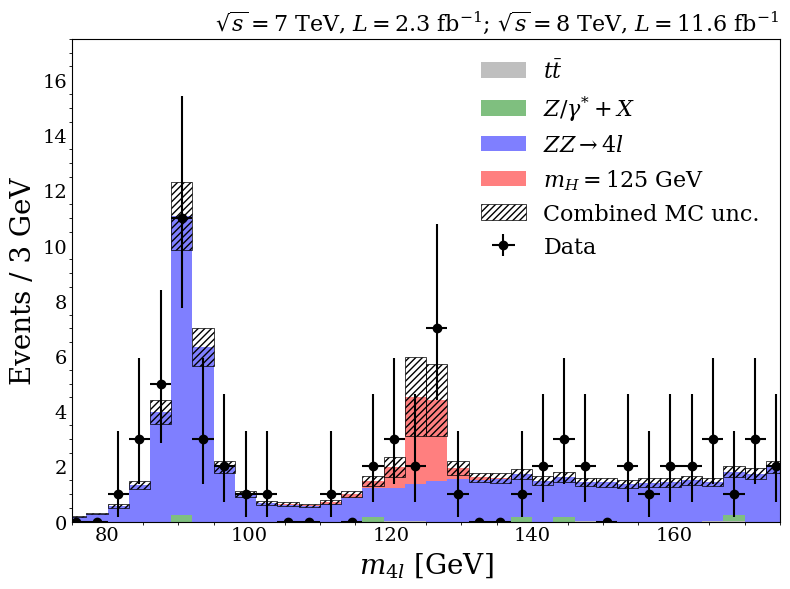

In [901]:
plt.figure(figsize=(8,6))

b_scale = m.values["b_scale"]
b_scale_err = m.errors["b_scale"]

s_scale = m_center.values["s_scale"]
s_scale_err = m_center.errors["s_scale"]

# Raw background only (no signal)
bkg_raw = hist_tt + hist_dy + hist_zz
bkg = b_scale * bkg_raw
bkg_unc = b_scale_err * bkg_raw


sig_unc = s_scale_err * hist_higgs

unc = np.sqrt(bkg_unc**2 + sig_unc**2)

############################
# Stacked MC (Higgs on top)
############################

# Make *copies* so original histograms are not modified
scaled_hist_tt = b_scale * hist_tt
scaled_hist_dy = b_scale * hist_dy
scaled_hist_zz = b_scale * hist_zz
scaled_hist_higgs = s_scale*hist_higgs  # signal is *not* scaled

stack_list = [scaled_hist_tt, scaled_hist_dy, scaled_hist_zz, scaled_hist_higgs]


bot = np.zeros_like(bincenter)

for label, color, component in zip(labels[::-1], colors[::-1], stack_list):
    plt.bar(
        bincenter, component,
        align='center', width=binwidth,
        bottom=bot, color=color, alpha=0.5,
        label=label
    )
    bot = bot + component

############################
# Background uncertainty band
############################
# Bin width half
half_width = binwidth * 0.5

# Plot vertical uncertainty bars with hatching
plt.bar(
    bincenter,
    2 * unc,            # full height = ±unc
    bottom=sum(stack_list) - unc,   # center the bar
    width=binwidth,
    fill=True,
    edgecolor="black",
    linewidth=0.5,
    hatch="/////",            # striped/hatching style
    color="none",           # transparent, only hatch visible
    alpha=1,
    label="Combined MC unc."
)



############################
# Plot data
############################
xerrs = np.full_like(bincenter, binwidth * 0.5)
yerrs = np.array(get_asymmetrical_uncertainties(hist))

plt.errorbar(
    bincenter, hist,
    xerr=xerrs, yerr=yerrs,
    fmt='o', color='black',
    label='Data'
)

############################
# Labels and formatting
############################
plt.title(r'$ \sqrt{s} = 7$ TeV, $L = 2.3$ fb$^{-1}$; $\sqrt{s} = 8$ TeV, $ L = 11.6$ fb$^{-1}$', 
          fontsize=16, position=(0.6,0.95))

plt.xlabel(r'$m_{4l}$ [GeV]', fontsize=20)
plt.ylabel(r'Events / 3 GeV', fontsize=20)
plt.xlim(75,175)
plt.ylim(0, 17.5)

plt.legend(fontsize=16, loc='upper right', frameon=False)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.minorticks_on()
plt.tight_layout()

plt.savefig("large_witherror_sscale.pdf")
plt.show()


<Figure size 800x600 with 0 Axes>

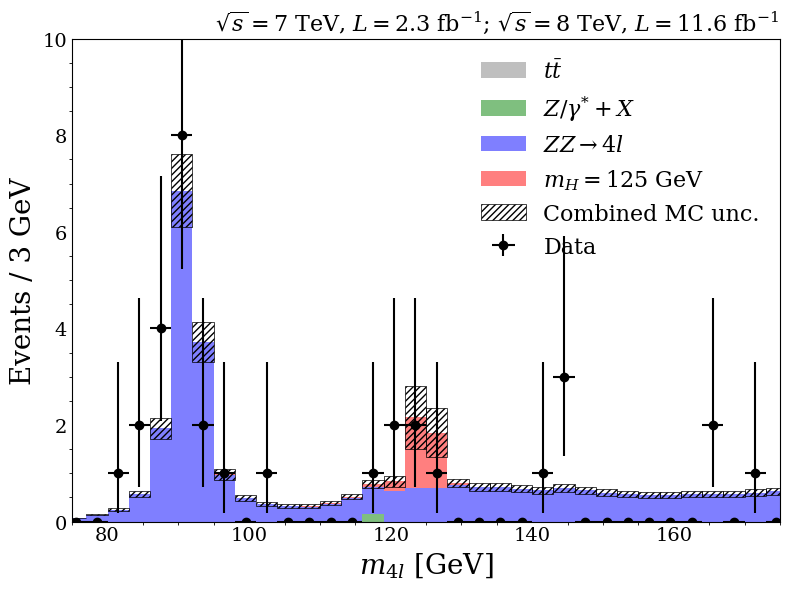

In [905]:
cut = 'PassSel == True & event_type == 3'

mc_higgs = [mc_higgs_11.query(cut), mc_higgs_12.query(cut)]
mc_zz = [mc_zz4mu_11.query(cut), mc_zz2mu2e_11.query(cut), mc_zz4e_11.query(cut), mc_zz4mu_12.query(cut), mc_zz2mu2e_12.query(cut), mc_zz4e_12.query(cut)]
mc_dy = [mc_dy10_11.query(cut), mc_dy50_11.query(cut), mc_dy10_12.query(cut), mc_dy50_12.query(cut)]
mc_tt = [mc_ttbar_11.query(cut), mc_ttbar_12.query(cut)]


hist_higgs = HistInvMass4l(mc_higgs,scales_higgs,rmin, rmax, nbins)
hist_zz = HistInvMass4l(mc_zz,scales_zz,rmin, rmax, nbins)
hist_dy= HistInvMass4l(mc_dy,scales_dy,rmin, rmax, nbins)
hist_tt= HistInvMass4l(mc_tt,scales_tt,rmin, rmax, nbins)

hist_mc = [hist_tt, hist_dy, hist_zz, hist_higgs]

## Now Plot it!!!

plt.figure(figsize = (8,6))
#plt.style.use('mystyle.mplstyle')


## data
inM_data = InvMass_4l(data_evt_sel.query(cut))
hist, bins = np.histogram(inM_data, bins = nbins, range = (rmin,rmax))
binwidth = bins[1] - bins[0]
bincenter = 0.5 * (bins[:-1] + bins[1:])


plt.figure(figsize=(8,6))

b_scale = m.values["b_scale"]
b_scale_err = m.errors["b_scale"]

s_scale = m_center.values["s_scale"]
s_scale_err = m_center.errors["s_scale"]

# Raw background only (no signal)
bkg_raw = hist_tt + hist_dy + hist_zz
bkg = b_scale * bkg_raw
bkg_unc = b_scale_err * bkg_raw


sig_unc = s_scale_err * hist_higgs

unc = np.sqrt(bkg_unc**2 + sig_unc**2)

############################
# Stacked MC (Higgs on top)
############################

# Make *copies* so original histograms are not modified
scaled_hist_tt = b_scale * hist_tt
scaled_hist_dy = b_scale * hist_dy
scaled_hist_zz = b_scale * hist_zz
scaled_hist_higgs = s_scale*hist_higgs  # signal is *not* scaled

stack_list = [scaled_hist_tt, scaled_hist_dy, scaled_hist_zz, scaled_hist_higgs]


bot = np.zeros_like(bincenter)

for label, color, component in zip(labels[::-1], colors[::-1], stack_list):
    plt.bar(
        bincenter, component,
        align='center', width=binwidth,
        bottom=bot, color=color, alpha=0.5,
        label=label
    )
    bot = bot + component

############################
# Background uncertainty band
############################
# Bin width half
half_width = binwidth * 0.5

# Plot vertical uncertainty bars with hatching
plt.bar(
    bincenter,
    2 * unc,            # full height = ±unc
    bottom=sum(stack_list) - unc,   # center the bar
    width=binwidth,
    fill=True,
    edgecolor="black",
    linewidth=0.5,
    hatch="/////",            # striped/hatching style
    color="none",           # transparent, only hatch visible
    alpha=1,
    label="Combined MC unc."
)



############################
# Plot data
############################
xerrs = np.full_like(bincenter, binwidth * 0.5)
yerrs = np.array(get_asymmetrical_uncertainties(hist))

plt.errorbar(
    bincenter, hist,
    xerr=xerrs, yerr=yerrs,
    fmt='o', color='black',
    label='Data'
)

############################
# Labels and formatting
############################
plt.title(r'$ \sqrt{s} = 7$ TeV, $L = 2.3$ fb$^{-1}$; $\sqrt{s} = 8$ TeV, $ L = 11.6$ fb$^{-1}$', 
          fontsize=16, position=(0.6,0.95))

plt.xlabel(r'$m_{4l}$ [GeV]', fontsize=20)
plt.ylabel(r'Events / 3 GeV', fontsize=20)
plt.xlim(75,175)
plt.ylim(0, 10)

plt.legend(fontsize=16, loc='upper right', frameon=False)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.minorticks_on()
plt.tight_layout()

plt.savefig("large_witherror_sscale_4mu.pdf")
plt.show()


In [647]:
def make_normalized_hist2d(x, y, bins):
    """
    Build a normalized 2D histogram and return its edges.
    """
    H, xedges, yedges = np.histogram2d(x, y, bins=bins, density=True)
    return H, xedges, yedges

def likelihood_ratio(df, H_sig, H_bkg, xedges, yedges):
    xvals = delta_R(df, 1,2).to_numpy()
    yvals = delta_R(df, 1,2).to_numpy()

    ix = np.searchsorted(xedges, xvals) - 1
    iy = np.searchsorted(yedges, yvals) - 1

    # Mask out-of-range points
    valid = (
        (ix >= 0) & (ix < H_sig.shape[0]) &
        (iy >= 0) & (iy < H_sig.shape[1])
    )

    lr = np.full_like(xvals, np.nan, dtype=float)

    # For valid points, compute likelihood ratio
    sig_vals = H_sig[ix[valid], iy[valid]]
    bkg_vals = H_bkg[ix[valid], iy[valid]]

    # Avoid division by zero
    ratio = np.divide(sig_vals, bkg_vals, out=np.zeros_like(sig_vals), where=bkg_vals>0)
    lr[valid] = ratio

    df["K_D"] = lr

    return 


bins2d = (np.arange(0, 5, 0.05), np.arange(0, 5, 0.05))

    # Build normalized histograms
H_sig, xedges, yedges = make_normalized_hist2d(
        delta_R(mc_sig, 1,2), delta_R(mc_sig, 3,4), bins2d)
H_bkg, _, _ = make_normalized_hist2d(
        delta_R(mc_bkg_zz, 1,2), delta_R(mc_bkg_zz, 3,4), bins2d)

likelihood_ratio(data, H_sig, H_bkg, xedges, yedges)

for mc in mc_list:
    likelihood_ratio(mc, H_sig, H_bkg, xedges, yedges)

In [114]:
cut = 'PassSel == True & K_D > 1'

mc_higgs = [mc_higgs_11.query(cut), mc_higgs_12.query(cut)]
mc_zz = [mc_zz4mu_11.query(cut), mc_zz2mu2e_11.query(cut), mc_zz4e_11.query(cut), mc_zz4mu_12.query(cut), mc_zz2mu2e_12.query(cut), mc_zz4e_12.query(cut)]
mc_dy = [mc_dy10_11.query(cut), mc_dy50_11.query(cut), mc_dy10_12.query(cut), mc_dy50_12.query(cut)]
mc_tt = [mc_ttbar_11.query(cut), mc_ttbar_12.query(cut)]

inM_data = InvMass_4l(data.query(cut))

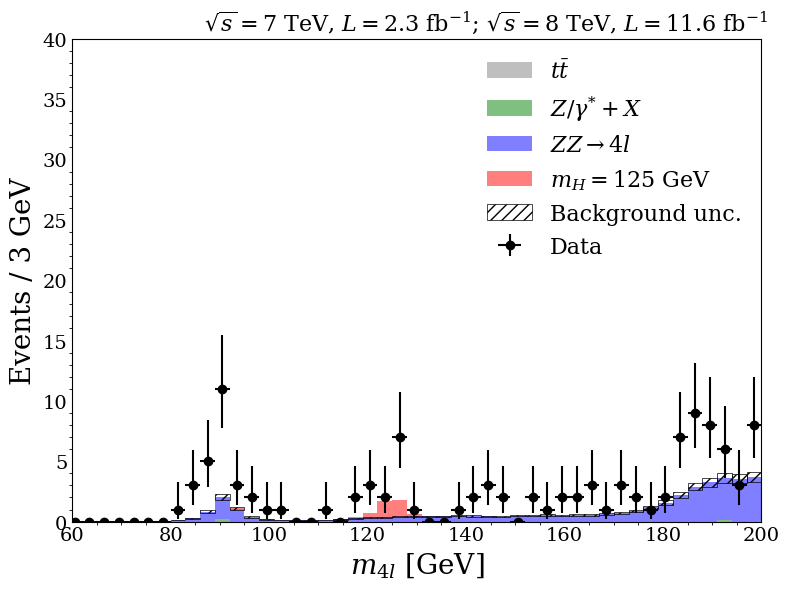

In [871]:
cut = 'PassSel == True & event_type == 1'

mc_higgs = [mc_higgs_11.query(cut), mc_higgs_12.query(cut)]
mc_zz = [mc_zz4mu_11.query(cut), mc_zz2mu2e_11.query(cut), mc_zz4e_11.query(cut), mc_zz4mu_12.query(cut), mc_zz2mu2e_12.query(cut), mc_zz4e_12.query(cut)]
mc_dy = [mc_dy10_11.query(cut), mc_dy50_11.query(cut), mc_dy10_12.query(cut), mc_dy50_12.query(cut)]
mc_tt = [mc_ttbar_11.query(cut), mc_ttbar_12.query(cut)]


rmin = 50
rmax = 200
nbins = 50

 
hist_higgs = HistInvMass4l(mc_higgs,scales_higgs,rmin, rmax, nbins)
hist_zz = HistInvMass4l(mc_zz,scales_zz,rmin, rmax, nbins)
hist_dy= HistInvMass4l(mc_dy,scales_dy,rmin, rmax, nbins)
hist_tt= HistInvMass4l(mc_tt,scales_tt,rmin, rmax, nbins)

hist_mc = [hist_tt, hist_dy, hist_zz, hist_higgs]

## data
hist, bins = np.histogram(inM_data, bins = nbins, range = (rmin,rmax))
binwidth = bins[1] - bins[0]
bincenter = 0.5 * (bins[:-1] + bins[1:])

plt.figure(figsize=(8,6))

b_scale = m.values["b_scale"]
b_scale_err = m.errors["b_scale"]

# Raw background only (no signal)
bkg_raw = hist_tt + hist_dy + hist_zz
bkg = b_scale * bkg_raw
bkg_unc = b_scale_err * bkg_raw

############################
# Stacked MC (Higgs on top)
############################

# Make *copies* so original histograms are not modified
scaled_hist_tt = b_scale * hist_tt
scaled_hist_dy = b_scale * hist_dy
scaled_hist_zz = b_scale * hist_zz
scaled_hist_higgs = hist_higgs  # signal is *not* scaled

stack_list = [scaled_hist_tt, scaled_hist_dy, scaled_hist_zz, scaled_hist_higgs]


bot = np.zeros_like(bincenter)

for label, color, component in zip(labels[::-1], colors[::-1], stack_list):
    plt.bar(
        bincenter, component,
        align='center', width=binwidth,
        bottom=bot, color=color, alpha=0.5,
        label=label
    )
    bot = bot + component

############################
# Background uncertainty band
############################
# Bin width half
half_width = binwidth * 0.5

# Plot vertical uncertainty bars with hatching
plt.bar(
    bincenter,
    2 * bkg_unc,            # full height = ±unc
    bottom=bkg - bkg_unc,   # center the bar
    width=binwidth,
    fill=True,
    edgecolor="black",
    linewidth=0.5,
    hatch="///",            # striped/hatching style
    color="none",           # transparent, only hatch visible
    alpha=1,
    label="Background unc."
)

############################
# Plot data
############################
xerrs = np.full_like(bincenter, binwidth * 0.5)
yerrs = np.array(get_asymmetrical_uncertainties(hist))

plt.errorbar(
    bincenter, hist,
    xerr=xerrs, yerr=yerrs,
    fmt='o', color='black',
    label='Data'
)

############################
# Labels and formatting
############################
plt.title(r'$ \sqrt{s} = 7$ TeV, $L = 2.3$ fb$^{-1}$; $\sqrt{s} = 8$ TeV, $ L = 11.6$ fb$^{-1}$', 
          fontsize=16, position=(0.6,0.95))

plt.xlabel(r'$m_{4l}$ [GeV]', fontsize=20)
plt.ylabel(r'Events / 3 GeV', fontsize=20)
plt.xlim(60,200)
plt.ylim(0, 40)

plt.legend(fontsize=16, loc='upper right', frameon=False)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.minorticks_on()
plt.tight_layout()

plt.savefig("large_witherror_KD.pdf")
plt.show()


In [116]:
null_model = m.values["b_scale"]*(hist_tt + hist_dy + hist_zz)
higgs_model =  null_model + hist_higgs
DLL = binned_DeltaLL(null_model,  higgs_model, hist, bincenter) 
print("observed significance:" ,np.sqrt(-2*DLL))

observed significance: 2.581723612011064


In [191]:
import xgboost as xgb
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier
#from catboost import CatBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve,auc
from sklearn.model_selection import cross_val_score

In [192]:
def train_bdt(train_vars, signal_proxy, bkg_proxy, eta_init=None):
    signal_df = signal_proxy
    background_df = bkg_proxy
    
    signal_df["category"]= 1 #Use 1 for signal
    background_df["category"] = 0 #use 0 for bkg
    training_data = pd.concat([signal_df[train_vars+['category']],background_df[train_vars+['category']]],copy=True,ignore_index=True,sort=False)
    training_data = training_data.sample(frac=1).reset_index(drop=True)
    training_data = training_data.dropna()
    
    mask = np.random.rand(len(training_data)) < 0.4
    _train_data = training_data.iloc[mask]
    _test_data = training_data.iloc[~mask]
    x,y = _train_data[train_vars],_train_data["category"]
    x_test,y_test = _test_data[train_vars],_test_data['category']
    
    var_list = train_vars
    
    min_len = min(signal_df.shape[0],background_df.shape[0])
    max_len = max(signal_df.shape[0],background_df.shape[0])
    
    
    imbalance = max_len/min_len
    kf = KFold(n_splits=5)
    x,y = training_data[var_list],training_data["category"]
    
    bdt = xgb.XGBClassifier(
            eta=eta_init,
            objective='binary:logistic',
            scale_pos_weight=imbalance,
            max_depth = 6
            ) 
    scores = cross_val_score(bdt,x,y,cv=kf,scoring='roc_auc')
    print(5*"#")
    print("Cross validation scores:")
    print(scores)
    print(np.mean(scores))
    print(5*"#")
    classifiers = []
    counter = 0
    for tri,tti in kf.split(x):
        counter+=1
        eta = eta_init
        x_train,y_train = x.iloc[tri],y.iloc[tri]
        x_test,y_test = x.iloc[tti],y.iloc[tti]
        bdt = xgb.XGBClassifier(
            eta=eta,
            objective='binary:logistic',
            scale_pos_weight=imbalance,
            max_depth = 6
            )
        #bdt = CatBoostClassifier(silent=True)
        classifiers.append(bdt)
        classifiers[-1].fit(x_train,y_train)
        
        fig,ax = plt.subplots(1,1, figsize = (3,3))
        mytype = 'xgb'
        proba_test = bdt.predict_proba(x_test)[:,1]
        fpr,tpr,_ = roc_curve(y_test,proba_test)
        area = auc(fpr,tpr)
        print(f'AUC: {area}')
        ax.plot(fpr,tpr, label = "ROC curve \n" r"learning rate $=$"+f"{eta}")
        ax.set_xlabel(r'1 - Bkg rejection')
        ax.set_ylabel(r'Signal efficiency')
        ax.legend()
        fig.tight_layout()
        fig.savefig(f'plots/roc-{eta}-{counter}.pdf')
        
        fig,ax = plt.subplots(1,1,figsize = (3,3))
        sig_test = bdt.predict_proba(x_test[np.array(y_test,dtype='bool')])[:,1]
        sig_train = bdt.predict_proba(x[np.array(y,dtype='bool')])[:,1]
        bkg_test = bdt.predict_proba(x_test[~np.array(y_test,dtype='bool')])[:,1]
        bkg_train = bdt.predict_proba(x[~np.array(y,dtype='bool')])[:,1]
        
        ax.hist(sig_test,bins=50,color='red',density=True,label='Signal test',alpha=0.7)
        ax.hist(sig_train,bins=50,color='red',histtype='step',density=True,label='Signal train')
        
        ax.hist(bkg_test,bins=50,density=True,label='Background test',alpha=0.7,color='C0')
        ax.hist(bkg_train,bins=50,histtype='step',density=True,label='Background train',alpha=0.7,color='C0')
        ax.set_xlabel(r'Classifier output')
        ax.set_ylabel('A.U.')
        ax.legend(loc = "upper right")
        fig.tight_layout()
        fig.savefig(f"plots/overtraining-{eta}-{counter}.pdf")
        
    return classifiers
        # x_signal = x_test[np.array(y_test,dtype='bool')]
        # x_bkg = x_test[~np.array(y_test,dtype='bool')]
        # punzi_figure(x_signal,x_background,[6000-3*150,6000+3*150])
        # punzi_figure(x_signal,x_background,[17000 -3*400, 17000 + 3*400])
        # plt.savefig(f"punzi-{counter}.pdf")

In [193]:
train_vars = [
#    'phi1',
    'eta1', 
    'pt1',  
#    'phi2',
    'eta2', 
    'pt2',  
#    'phi3',
    'eta3', 
    'pt3',  
#    'phi4',
    'eta4',
    'pt4'
]

In [194]:
mc_higgs = [mc_higgs_11, mc_higgs_12]
mc_zz = [mc_zz4mu_11, mc_zz2mu2e_11, mc_zz4e_11, mc_zz4mu_12, mc_zz2mu2e_12, mc_zz4e_12]
mc_dy = [mc_dy10_11, mc_dy50_11, mc_dy10_12, mc_dy50_12]
mc_tt = [mc_ttbar_11, mc_ttbar_12]

mc_sig = pd.concat(mc_higgs,axis=0,ignore_index=True)
mc_bkg_zz = pd.concat(mc_zz,axis=0,ignore_index=True)
mc_bkg_dy = pd.concat(mc_dy,axis=0,ignore_index=True)
mc_bkg_tt = pd.concat(mc_tt,axis=0,ignore_index=True)

/var/folders/rz/wj7nq3j14wx3gj_18_bwmwxm0000gq/T/ipykernel_51572/901947145.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  signal_df["category"]= 1 #Use 1 for signal


#####
Cross validation scores:
[0.96099402 0.96043958 0.96085075 0.96146039 0.96050431]
0.9608498088698456
#####
AUC: 0.9609940166457565
AUC: 0.9604395768031364
AUC: 0.96085074878693
AUC: 0.9614603906967075
AUC: 0.9605043114166973


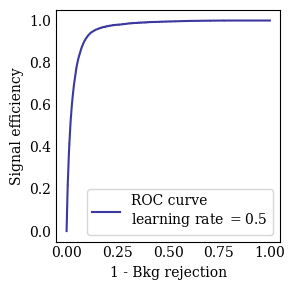

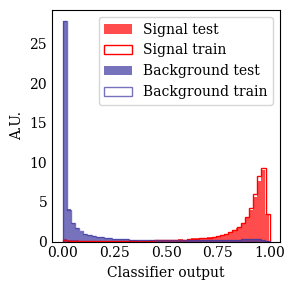

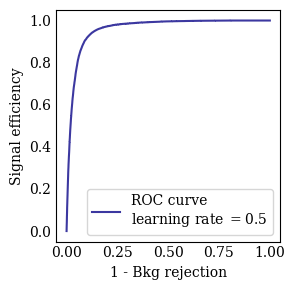

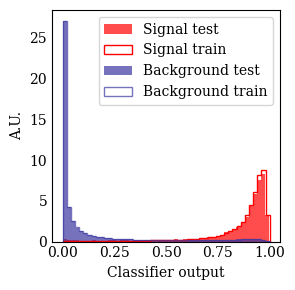

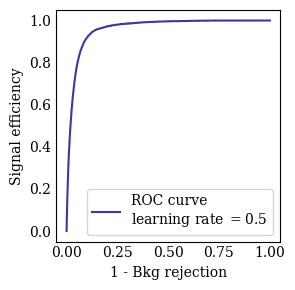

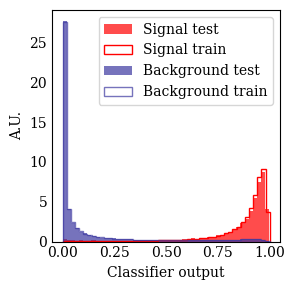

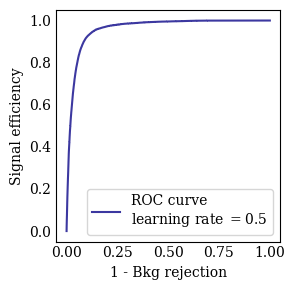

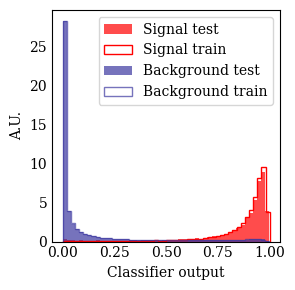

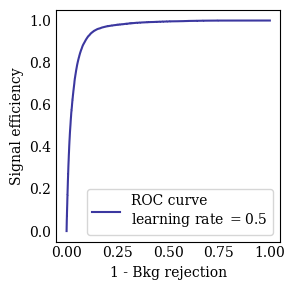

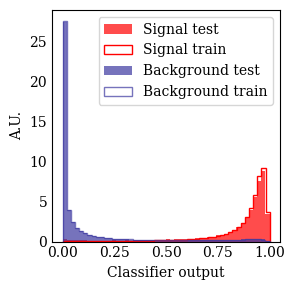

In [195]:
signal_proxy = mc_sig.query('PassSel == True & event_type != 0')
bkg_proxy = pd.concat([mc_bkg_zz, mc_bkg_dy, mc_bkg_tt], axis=0, ignore_index=True)

classifiers_all = train_bdt(train_vars, signal_proxy, bkg_proxy, 0.5)

In [196]:
def predict(df, classifiers): # Define your probability threshold
    raw = df[train_vars]
    for i, bdt in enumerate(classifiers, start = 1):
        df[f'prob_sig{i}'] = bdt.predict_proba(raw)[:, 1]
        df[f'prob_bkg{i}'] = bdt.predict_proba(raw)[:, 0]
    return df

In [ ]:
signal_proxy = mc_sig.query('PassSel == True & event_type == 1')
bkg_proxy = pd.concat([mc_bkg_zz, mc_bkg_dy, mc_bkg_tt, data.query("m4l>180 or m4l<80")], axis=0, ignore_index=True)

classifiers_1 = train_bdt(train_vars, signal_proxy, bkg_proxy, 0.5)

signal_proxy = mc_sig.query('PassSel == True & event_type == 2')
bkg_proxy = pd.concat([mc_bkg_zz, mc_bkg_dy, mc_bkg_tt, data.query("m4l>180 or m4l<80")], axis=0, ignore_index=True)

classifiers_2 = train_bdt(train_vars, signal_proxy, bkg_proxy, 0.5)

signal_proxy = mc_sig.query('PassSel == True & event_type == 3')
bkg_proxy = pd.concat([mc_bkg_zz, mc_bkg_dy, mc_bkg_tt, data.query("m4l>180 or m4l<80")], axis=0, ignore_index=True)

classifiers_3 = train_bdt(train_vars, signal_proxy, bkg_proxy, 0.5)

In [197]:
#classifiers = classifiers_1 + classifiers_2 + classifiers_3
classifiers = classifiers_all

data = predict(data, classifiers)

for i,bkg in enumerate(mc_all):
    for j,pro in enumerate(bkg):
        mc_all[i][j] = predict(pro , classifiers )

In [198]:
def apply_bdt_selection(df, separate = False):


    bdt_res = (df['prob_sig1']/(df['prob_sig1']+df['prob_bkg1']) +
               df['prob_sig2']/(df['prob_sig2']+df['prob_bkg2']) +
               df['prob_sig3']/(df['prob_sig3']+df['prob_bkg3']) +
               df['prob_sig4']/(df['prob_sig4']+df['prob_bkg4']) +
               df['prob_sig5']/(df['prob_sig5']+df['prob_bkg5']) >5*0.5)

#    bdt_res = (df['prob_sig1'] +
#               df['prob_sig2'] +
#               df['prob_sig3'] +
#               df['prob_sig4'] +
#               df['prob_sig5'] > 5*0.5)

        
    # Apply final event selection mask
    df['PassBdt'] =  bdt_res  # you can extend with additional cuts if needed

    return df

### Apply object selection and event selection to data and each MC process###
data_obj_sel = object_selection(data)
data_evt_sel = apply_bdt_selection(data_obj_sel)

print('eff on data: ' , (data.query('PassBdt == True').shape[0]/ data.shape[0]))

for i,bkg in enumerate(mc_all):
    for j,pro in enumerate(bkg):
        mc_all[i][j] = apply_bdt_selection(object_selection(pro))

print('eff on signal: ' , (mc_higgs_11.query('PassSel ==True and PassBdt == True').shape[0]+ mc_higgs_12.query('PassSel ==True and PassBdt == True').shape[0])/(mc_higgs_11.shape[0]+mc_higgs_12.shape[0]))

eff on data:  0.05690161527165932
eff on signal:  0.7878268555045377


b expected:  8.059485833425462
s expected:  9.324652942041881
expected excess: 3.284573680119476
s+b observed:  19


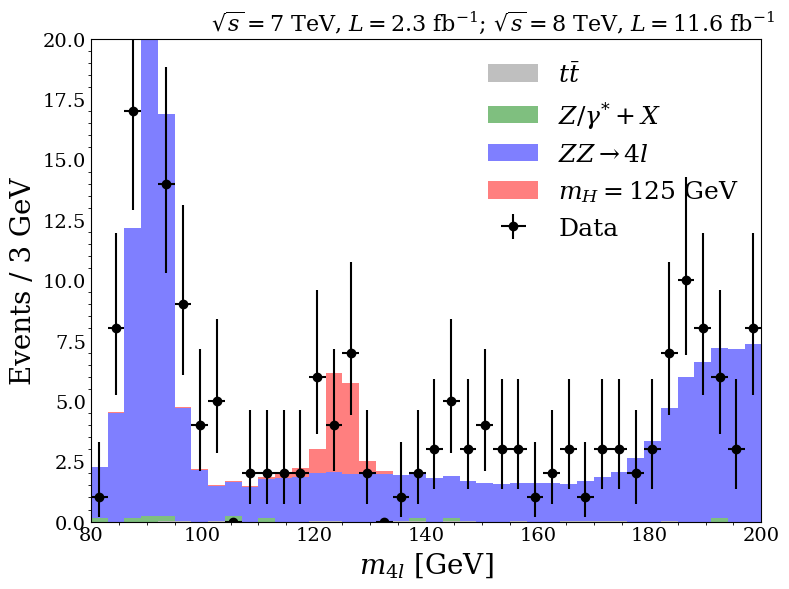

In [201]:
cut = 'PassSel == True '

mc_higgs = [mc_higgs_11.query(cut), mc_higgs_12.query(cut)]
mc_zz = [mc_zz4mu_11.query(cut), mc_zz2mu2e_11.query(cut), mc_zz4e_11.query(cut), mc_zz4mu_12.query(cut), mc_zz2mu2e_12.query(cut), mc_zz4e_12.query(cut)]
mc_dy = [mc_dy10_11.query(cut), mc_dy50_11.query(cut), mc_dy10_12.query(cut), mc_dy50_12.query(cut)]
mc_tt = [mc_ttbar_11.query(cut), mc_ttbar_12.query(cut)]

rmin = 50
rmax = 200
nbins = 50

 
hist_higgs = HistInvMass4l(mc_higgs,scales_higgs,rmin, rmax, nbins)
hist_zz = HistInvMass4l(mc_zz,scales_zz,rmin, rmax, nbins)
hist_dy= HistInvMass4l(mc_dy,scales_dy,rmin, rmax, nbins)
hist_tt= HistInvMass4l(mc_tt,scales_tt,rmin, rmax, nbins)

hist_mc = [hist_tt, hist_dy, hist_zz, hist_higgs]


## data
inM_data = InvMass_4l(data_evt_sel.query(cut))
hist, bins = np.histogram(inM_data, bins = nbins, range = (rmin,rmax))
binwidth = bins[1] - bins[0]
bincenter = 0.5 * (bins[:-1] + bins[1:]) 


mask = np.where((119 < bincenter) & (bincenter < 131) )
bincenter[mask]
print("b expected: ", np.sum(hist_zz[mask]) + np.sum(hist_dy[mask]) + np.sum(hist_tt[mask]))
print("s expected: ", np.sum(hist_higgs[mask]))
print("expected excess:", np.sum(hist_higgs[mask])/np.sqrt(np.sum(hist_zz[mask]) + np.sum(hist_dy[mask]) + np.sum(hist_tt[mask]))) 
print("s+b observed: ", np.sum(hist[mask]))


## Now Plot it!!!

plt.figure(figsize = (8,6))
for i,pro in enumerate(hist_mc):
    if i == 0:
        stack = plt.bar(bincenter, pro, align = 'center', width = binwidth, color = colors[3-i], label=labels[3-i],
                 alpha = 0.5)
        bot = pro
    else:
        stack = plt.bar(bincenter, pro, align = 'center', width = binwidth, color = colors[3-i], label=labels[3-i],
                 bottom = bot, alpha = 0.5)
        bot = bot + pro



## Measured data
xerrs = [binwidth*0.5 for i in range(0, nbins)]
yerrs = np.array(get_asymmetrical_uncertainties(hist))
marker_data = plt.errorbar(bincenter, hist, xerr = xerrs, yerr = yerrs, linestyle = 'None', color = 'black',
                        marker = 'o', label = r'Data')



plt.title(r'$ \sqrt{s} = 7$ TeV, $L = 2.3$ fb$^{-1}$; $\sqrt{s} = 8$ TeV, $ L = 11.6$ fb$^{-1}$', fontsize = 16, position=(0.6,0.95))
plt.xlabel(r'$m_{4l}$ [GeV]',fontsize = 20, position=(0.92,0.1))
plt.ylabel(r'Events / 3 GeV',fontsize = 20, position=(0.1,0.84))
plt.xlim(80,200)
plt.ylim(0,20)
plt.legend(fontsize = 18, loc = 'upper right', frameon = False)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.minorticks_on()
plt.tight_layout()
plt.savefig("large_nobdt.pdf")
plt.show()

b expected:  6.666147431240705
s expected:  9.054093814345494
expected excess: 3.50677202147496
s+b observed:  16


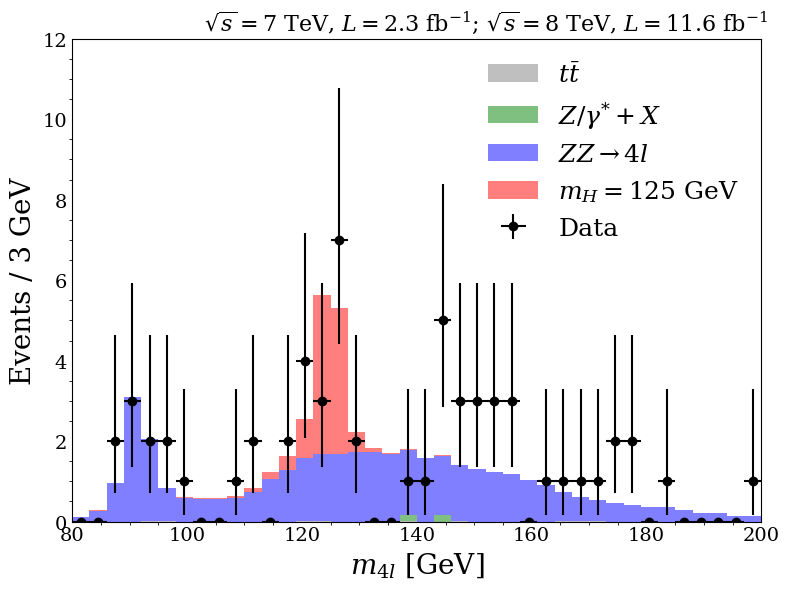

In [202]:
cut_bdt = ' PassBdt == True & PassSel == True '

mc_higgs = [mc_higgs_11.query(cut_bdt), mc_higgs_12.query(cut_bdt)]
mc_zz = [mc_zz4mu_11.query(cut_bdt), mc_zz2mu2e_11.query(cut_bdt), mc_zz4e_11.query(cut_bdt), mc_zz4mu_12.query(cut_bdt), mc_zz2mu2e_12.query(cut_bdt), mc_zz4e_12.query(cut_bdt)]
mc_dy = [mc_dy10_11.query(cut_bdt), mc_dy50_11.query(cut_bdt), mc_dy10_12.query(cut_bdt), mc_dy50_12.query(cut_bdt)]
mc_tt = [mc_ttbar_11.query(cut_bdt), mc_ttbar_12.query(cut_bdt)]

rmin = 50
rmax = 200
nbins = 50

 
hist_higgs = HistInvMass4l(mc_higgs,scales_higgs,rmin, rmax, nbins)
hist_zz = HistInvMass4l(mc_zz,scales_zz,rmin, rmax, nbins)
hist_dy= HistInvMass4l(mc_dy,scales_dy,rmin, rmax, nbins)
hist_tt= HistInvMass4l(mc_tt,scales_tt,rmin, rmax, nbins)

hist_mc = [hist_tt, hist_dy, hist_zz, hist_higgs]


## data
inM_data = InvMass_4l(data_evt_sel.query(cut_bdt))
hist, bins = np.histogram(inM_data, bins = nbins, range = (rmin,rmax))
binwidth = bins[1] - bins[0]
bincenter = 0.5 * (bins[:-1] + bins[1:]) 


mask = np.where((119 < bincenter) & (bincenter < 131) )
bincenter[mask]
print("b expected: ", np.sum(hist_zz[mask]) + np.sum(hist_dy[mask]) + np.sum(hist_tt[mask]))
print("s expected: ", np.sum(hist_higgs[mask]))
print("expected excess:", np.sum(hist_higgs[mask])/np.sqrt(np.sum(hist_zz[mask]) + np.sum(hist_dy[mask]) + np.sum(hist_tt[mask]))) 
print("s+b observed: ", np.sum(hist[mask]))


## Now Plot it!!!

plt.figure(figsize = (8,6))
for i,pro in enumerate(hist_mc):
    if i == 0:
        stack = plt.bar(bincenter, pro, align = 'center', width = binwidth, color = colors[3-i], label=labels[3-i],
                 alpha = 0.5)
        bot = pro
    else:
        stack = plt.bar(bincenter, pro, align = 'center', width = binwidth, color = colors[3-i], label=labels[3-i],
                 bottom = bot, alpha = 0.5)
        bot = bot + pro



## Measured data
xerrs = [binwidth*0.5 for i in range(0, nbins)]
yerrs = np.array(get_asymmetrical_uncertainties(hist))
marker_data = plt.errorbar(bincenter, hist, xerr = xerrs, yerr = yerrs, linestyle = 'None', color = 'black',
                        marker = 'o', label = r'Data')



plt.title(r'$ \sqrt{s} = 7$ TeV, $L = 2.3$ fb$^{-1}$; $\sqrt{s} = 8$ TeV, $ L = 11.6$ fb$^{-1}$', fontsize = 16, position=(0.6,0.95))
plt.xlabel(r'$m_{4l}$ [GeV]',fontsize = 20, position=(0.92,0.1))
plt.ylabel(r'Events / 3 GeV',fontsize = 20, position=(0.1,0.84))
plt.xlim(80,200)
plt.ylim(0,12)
plt.legend(fontsize = 18, loc = 'upper right', frameon = False)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.minorticks_on()
plt.tight_layout()
plt.savefig("large.pdf")
plt.show()

In [203]:
# display iminuit version
import iminuit

# everything in iminuit is done through the Minuit object, so we import it
from iminuit import minimize  # has same interface as scipy.optimize.minimize
from iminuit import Minuit, describe


In [204]:
def binned_NLL_side(model, data, bincenter):
   
    side_range = np.intersect1d( 
        np.union1d( np.where(bincenter<100), np.where(bincenter>160) ), 
        np.where(model>0)
                               )
    model = np.asarray(model[side_range])
    data = np.asarray(data[side_range]) 

    LL = data*np.log(model) - model - np.log(scipy.special.gamma(data+1))
    
    return -np.sum(LL)
    
    
def NLL_minuit(b_scale):
    model = b_scale * (hist_mc[0]+hist_mc[1]+hist_mc[2])
    return binned_NLL_side(model, hist, bincenter)




In [205]:
m = Minuit(NLL_minuit, b_scale=1.0)   # initial guess
#m.errordef = Minuit.LIKELIHOOD        # for NLL minimization

m.limits["b_scale"] = (0, None)       # optional: force positive scale

m.migrad()                            # run minimization

print(m.values["b_scale"])
print(m.errors["b_scale"])

1.4885256161909166
0.46904284880068947


b expected:  9.922731212707067
s expected:  9.054093814345494
expected excess: 2.874282008754038
s+b observed:  16


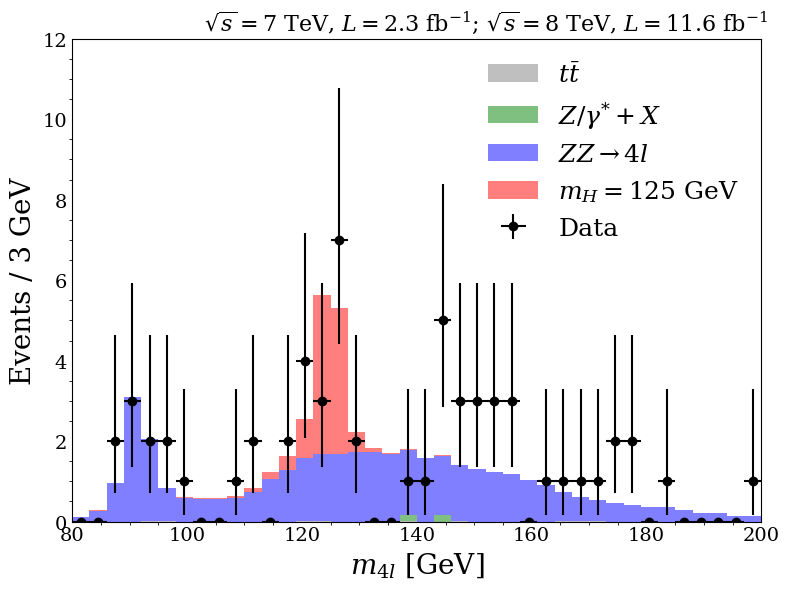

In [206]:
cut_bdt = ' PassBdt == True & PassSel == True '

mc_higgs = [mc_higgs_11.query(cut_bdt), mc_higgs_12.query(cut_bdt)]
mc_zz = [mc_zz4mu_11.query(cut_bdt), mc_zz2mu2e_11.query(cut_bdt), mc_zz4e_11.query(cut_bdt), mc_zz4mu_12.query(cut_bdt), mc_zz2mu2e_12.query(cut_bdt), mc_zz4e_12.query(cut_bdt)]
mc_dy = [mc_dy10_11.query(cut_bdt), mc_dy50_11.query(cut_bdt), mc_dy10_12.query(cut_bdt), mc_dy50_12.query(cut_bdt)]
mc_tt = [mc_ttbar_11.query(cut_bdt), mc_ttbar_12.query(cut_bdt)]

rmin = 50
rmax = 200
nbins = 50

 
hist_higgs = HistInvMass4l(mc_higgs,scales_higgs,rmin, rmax, nbins)
hist_zz = HistInvMass4l(mc_zz,scales_zz,rmin, rmax, nbins)
hist_dy= HistInvMass4l(mc_dy,scales_dy,rmin, rmax, nbins)
hist_tt= HistInvMass4l(mc_tt,scales_tt,rmin, rmax, nbins)

hist_mc = [hist_tt, hist_dy, hist_zz, hist_higgs]


## data
inM_data = InvMass_4l(data_evt_sel.query(cut_bdt))
hist, bins = np.histogram(inM_data, bins = nbins, range = (rmin,rmax))
binwidth = bins[1] - bins[0]
bincenter = 0.5 * (bins[:-1] + bins[1:]) 


mask = np.where((119 < bincenter) & (bincenter < 131) )
bincenter[mask]
print("b expected: ", m.values["b_scale"]*(np.sum(hist_zz[mask]) + np.sum(hist_dy[mask]) + np.sum(hist_tt[mask])) )
print("s expected: ", np.sum(hist_higgs[mask]))
print("expected excess:", np.sum(hist_higgs[mask])/np.sqrt(m.values["b_scale"]*(np.sum(hist_zz[mask]) + np.sum(hist_dy[mask]) + np.sum(hist_tt[mask])))) 
print("s+b observed: ", np.sum(hist[mask]))


## Now Plot it!!!

plt.figure(figsize = (8,6))
for i,pro in enumerate(hist_mc):
    if i == 0:
        pro
        stack = plt.bar(bincenter, pro, align = 'center', width = binwidth, color = colors[3-i], label=labels[3-i],
                 alpha = 0.5)
        bot = pro
    else:

        stack = plt.bar(bincenter, pro, align = 'center', width = binwidth, color = colors[3-i], label=labels[3-i],
                 bottom = bot, alpha = 0.5)
        bot = bot + pro



## Measured data
xerrs = [binwidth*0.5 for i in range(0, nbins)]
yerrs = np.array(get_asymmetrical_uncertainties(hist))
marker_data = plt.errorbar(bincenter, hist, xerr = xerrs, yerr = yerrs, linestyle = 'None', color = 'black',
                        marker = 'o', label = r'Data')




plt.title(r'$ \sqrt{s} = 7$ TeV, $L = 2.3$ fb$^{-1}$; $\sqrt{s} = 8$ TeV, $ L = 11.6$ fb$^{-1}$', fontsize = 16, position=(0.6,0.95))
plt.xlabel(r'$m_{4l}$ [GeV]',fontsize = 20, position=(0.92,0.1))
plt.ylabel(r'Events / 3 GeV',fontsize = 20, position=(0.1,0.84))
plt.xlim(80,200)
plt.ylim(0,12)
plt.legend(fontsize = 18, loc = 'upper right', frameon = False)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.minorticks_on()
plt.tight_layout()
plt.savefig("large_witherror.pdf")
plt.show()

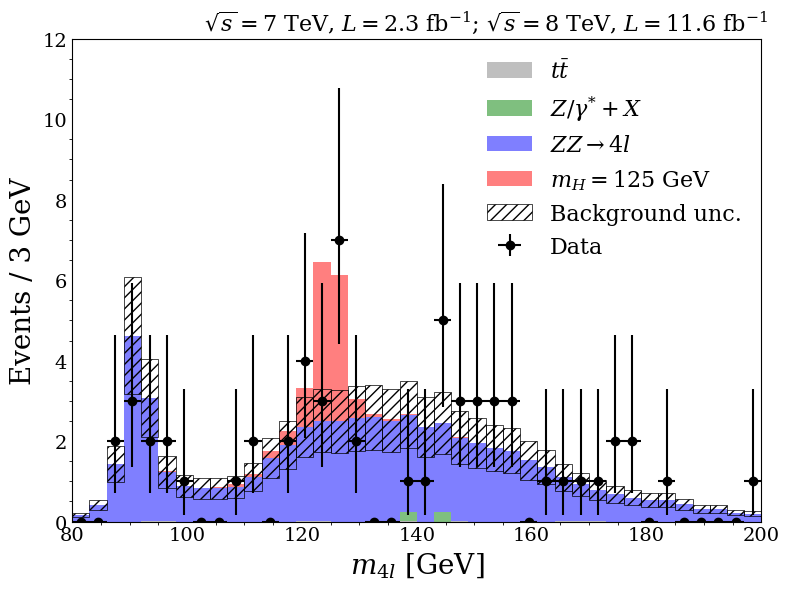

In [207]:
plt.figure(figsize=(8,6))

b_scale = m.values["b_scale"]
b_scale_err = m.errors["b_scale"]

# Raw background only (no signal)
bkg_raw = hist_tt + hist_dy + hist_zz
bkg = b_scale * bkg_raw
bkg_unc = b_scale_err * bkg_raw

############################
# Stacked MC (Higgs on top)
############################

# Make *copies* so original histograms are not modified
scaled_hist_tt = b_scale * hist_tt
scaled_hist_dy = b_scale * hist_dy
scaled_hist_zz = b_scale * hist_zz
scaled_hist_higgs = hist_higgs  # signal is *not* scaled

stack_list = [scaled_hist_tt, scaled_hist_dy, scaled_hist_zz, scaled_hist_higgs]


bot = np.zeros_like(bincenter)

for label, color, component in zip(labels[::-1], colors[::-1], stack_list):
    plt.bar(
        bincenter, component,
        align='center', width=binwidth,
        bottom=bot, color=color, alpha=0.5,
        label=label
    )
    bot = bot + component

############################
# Background uncertainty band
############################
# Bin width half
half_width = binwidth * 0.5

# Plot vertical uncertainty bars with hatching
plt.bar(
    bincenter,
    2 * bkg_unc,            # full height = ±unc
    bottom=bkg - bkg_unc,   # center the bar
    width=binwidth,
    fill=True,
    edgecolor="black",
    linewidth=0.5,
    hatch="///",            # striped/hatching style
    color="none",           # transparent, only hatch visible
    alpha=1,
    label="Background unc."
)

############################
# Plot data
############################
xerrs = np.full_like(bincenter, binwidth * 0.5)
yerrs = np.array(get_asymmetrical_uncertainties(hist))

plt.errorbar(
    bincenter, hist,
    xerr=xerrs, yerr=yerrs,
    fmt='o', color='black',
    label='Data'
)

############################
# Labels and formatting
############################
plt.title(r'$ \sqrt{s} = 7$ TeV, $L = 2.3$ fb$^{-1}$; $\sqrt{s} = 8$ TeV, $ L = 11.6$ fb$^{-1}$', 
          fontsize=16, position=(0.6,0.95))

plt.xlabel(r'$m_{4l}$ [GeV]', fontsize=20)
plt.ylabel(r'Events / 3 GeV', fontsize=20)
plt.xlim(80,200)
plt.ylim(0, 12)

plt.legend(fontsize=16, loc='upper right', frameon=False)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.minorticks_on()
plt.tight_layout()

plt.savefig("large_witherror.pdf")
plt.show()


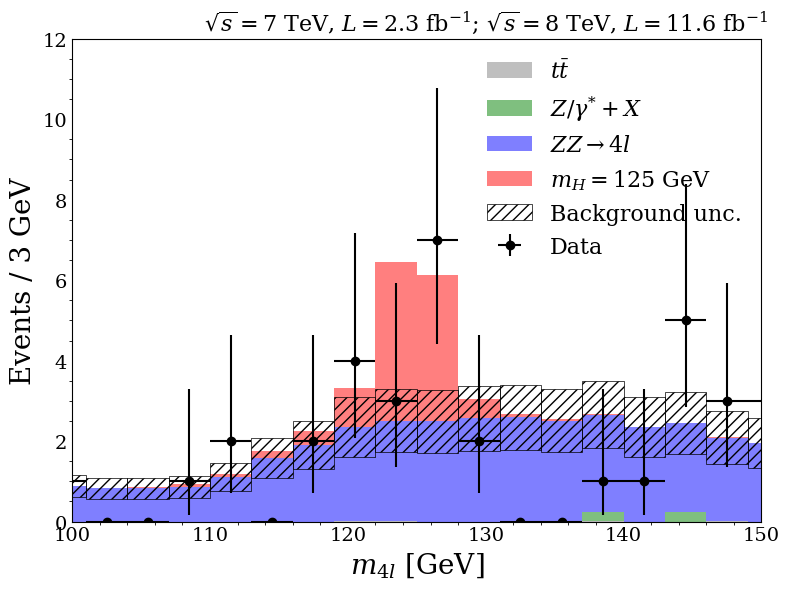

In [208]:
plt.figure(figsize=(8,6))

b_scale = m.values["b_scale"]
b_scale_err = m.errors["b_scale"]

# Raw background only (no signal)
bkg_raw = hist_tt + hist_dy + hist_zz
bkg = b_scale * bkg_raw
bkg_unc = b_scale_err * bkg_raw

############################
# Stacked MC (Higgs on top)
############################

# Make *copies* so original histograms are not modified
scaled_hist_tt = b_scale * hist_tt
scaled_hist_dy = b_scale * hist_dy
scaled_hist_zz = b_scale * hist_zz
scaled_hist_higgs = hist_higgs  # signal is *not* scaled

stack_list = [scaled_hist_tt, scaled_hist_dy, scaled_hist_zz, scaled_hist_higgs]


bot = np.zeros_like(bincenter)

for label, color, component in zip(labels[::-1], colors[::-1], stack_list):
    plt.bar(
        bincenter, component,
        align='center', width=binwidth,
        bottom=bot, color=color, alpha=0.5,
        label=label
    )
    bot = bot + component

############################
# Background uncertainty band
############################
# Bin width half
half_width = binwidth * 0.5

# Plot vertical uncertainty bars with hatching
plt.bar(
    bincenter,
    2 * bkg_unc,            # full height = ±unc
    bottom=bkg - bkg_unc,   # center the bar
    width=binwidth,
    fill=True,
    edgecolor="black",
    linewidth=0.5,
    hatch="///",            # striped/hatching style
    color="none",           # transparent, only hatch visible
    alpha=1,
    label="Background unc."
)

############################
# Plot data
############################
xerrs = np.full_like(bincenter, binwidth * 0.5)
yerrs = np.array(get_asymmetrical_uncertainties(hist))

plt.errorbar(
    bincenter, hist,
    xerr=xerrs, yerr=yerrs,
    fmt='o', color='black',
    label='Data'
)

############################
# Labels and formatting
############################
plt.title(r'$ \sqrt{s} = 7$ TeV, $L = 2.3$ fb$^{-1}$; $\sqrt{s} = 8$ TeV, $ L = 11.6$ fb$^{-1}$', 
          fontsize=16, position=(0.6,0.95))

plt.xlabel(r'$m_{4l}$ [GeV]', fontsize=20)
plt.ylabel(r'Events / 3 GeV', fontsize=20)
plt.xlim(100,150)
plt.ylim(0, 12)

plt.legend(fontsize=16, loc='upper right', frameon=False)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.minorticks_on()
plt.tight_layout()

plt.savefig("small_witherror.pdf")
plt.show()


In [209]:
null_model = m.values["b_scale"]*(hist_tt + hist_dy + hist_zz)
higgs_model =  null_model + hist_higgs

print( binned_LL(null_model, higgs_model, bincenter) )
significance = np.sqrt(-binned_LL(null_model, higgs_model, bincenter))

print("expected significance:" ,significance) 

null_model = m.values["b_scale"]*(hist_tt + hist_dy + hist_zz)
higgs_model =  null_model + hist_higgs
DLL = binned_DeltaLL(null_model,  higgs_model, hist, bincenter) 
print("observed significance:" ,np.sqrt(-2*DLL))

[-1.72522415 -4.01920882 -3.71687649 -1.54908657]
-11.010396033666328
[-1.72522415 -4.01920882 -3.71687649 -1.54908657]
expected significance: 3.3181916812725465
[23 24 25 26]
observed significance: 1.9072525444558068


b expected:  2.5252220274811847
s expected:  4.129463410809891
s+b observed:  7


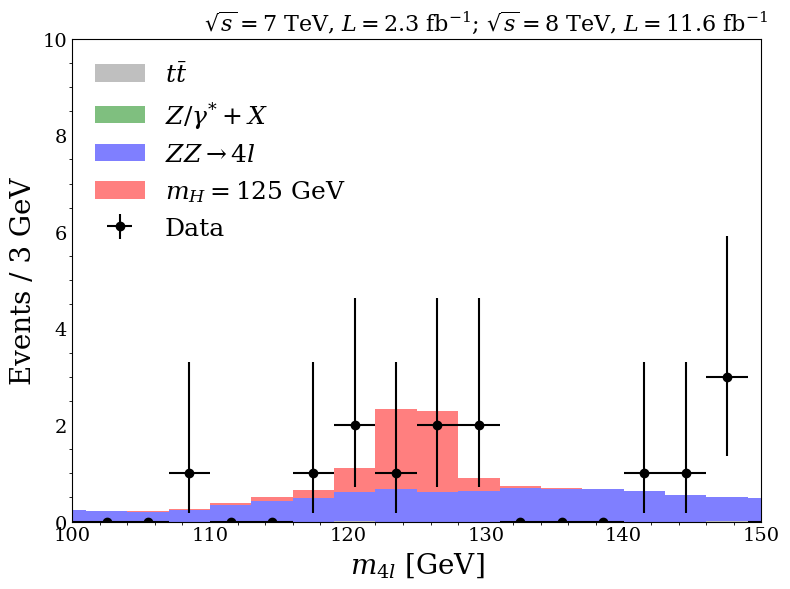

In [77]:
cut_bdt = ' PassBdt == True & PassSel == True & event_type == 1 '

mc_higgs = [mc_higgs_11.query(cut_bdt), mc_higgs_12.query(cut_bdt)]
mc_zz = [mc_zz4mu_11.query(cut_bdt), mc_zz2mu2e_11.query(cut_bdt), mc_zz4e_11.query(cut_bdt), mc_zz4mu_12.query(cut_bdt), mc_zz2mu2e_12.query(cut_bdt), mc_zz4e_12.query(cut_bdt)]
mc_dy = [mc_dy10_11.query(cut_bdt), mc_dy50_11.query(cut_bdt), mc_dy10_12.query(cut_bdt), mc_dy50_12.query(cut_bdt)]
mc_tt = [mc_ttbar_11.query(cut_bdt), mc_ttbar_12.query(cut_bdt)]

rmin = 50
rmax = 200
nbins = 50

 
hist_higgs = HistInvMass4l(mc_higgs,scales_higgs,rmin, rmax, nbins)
hist_zz = HistInvMass4l(mc_zz,scales_zz,rmin, rmax, nbins)
hist_dy= HistInvMass4l(mc_dy,scales_dy,rmin, rmax, nbins)
hist_tt= HistInvMass4l(mc_tt,scales_tt,rmin, rmax, nbins)

hist_mc = [hist_tt, hist_dy, hist_zz, hist_higgs]


## data
inM_data = InvMass_4l(data_evt_sel.query(cut_bdt))
hist, bins = np.histogram(inM_data, bins = nbins, range = (rmin,rmax))
binwidth = bins[1] - bins[0]
bincenter = 0.5 * (bins[:-1] + bins[1:]) 


mask = np.where((119 < bincenter) & (bincenter < 131) )
bincenter[mask]
print("b expected: ", np.sum(hist_zz[mask]) + np.sum(hist_dy[mask]) + np.sum(hist_tt[mask]))
print("s expected: ", np.sum(hist_higgs[mask]))
print("s+b observed: ", np.sum(hist[mask]))


## Now Plot it!!!

plt.figure(figsize = (8,6))
for i,pro in enumerate(hist_mc):
    if i == 0:
        stack = plt.bar(bincenter, pro, align = 'center', width = binwidth, color = colors[3-i], label=labels[3-i],
                 alpha = 0.5)
        bot = pro
    else:
        stack = plt.bar(bincenter, pro, align = 'center', width = binwidth, color = colors[3-i], label=labels[3-i],
                 bottom = bot, alpha = 0.5)
        bot = bot + pro



## Measured data
xerrs = [binwidth*0.5 for i in range(0, nbins)]
yerrs = np.array(get_asymmetrical_uncertainties(hist))
marker_data = plt.errorbar(bincenter, hist, xerr = xerrs, yerr = yerrs, linestyle = 'None', color = 'black',
                        marker = 'o', label = r'Data')



plt.title(r'$ \sqrt{s} = 7$ TeV, $L = 2.3$ fb$^{-1}$; $\sqrt{s} = 8$ TeV, $L = 11.6$ fb$^{-1}$', fontsize = 16, position=(0.6,0.95))
plt.xlabel(r'$m_{4l}$ [GeV]',fontsize = 20, position=(0.92,0.1))
plt.ylabel(r'Events / 3 GeV',fontsize = 20, position=(0.1,0.84))
plt.xlim(100,150)
plt.ylim(0,10)
plt.legend(fontsize = 18, loc = 'upper left', frameon = False)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.minorticks_on()
plt.tight_layout()
plt.savefig("2e2mu.pdf")
plt.show()

b expected:  1.3938756446575045
s expected:  1.7656554185702305
s+b observed:  4


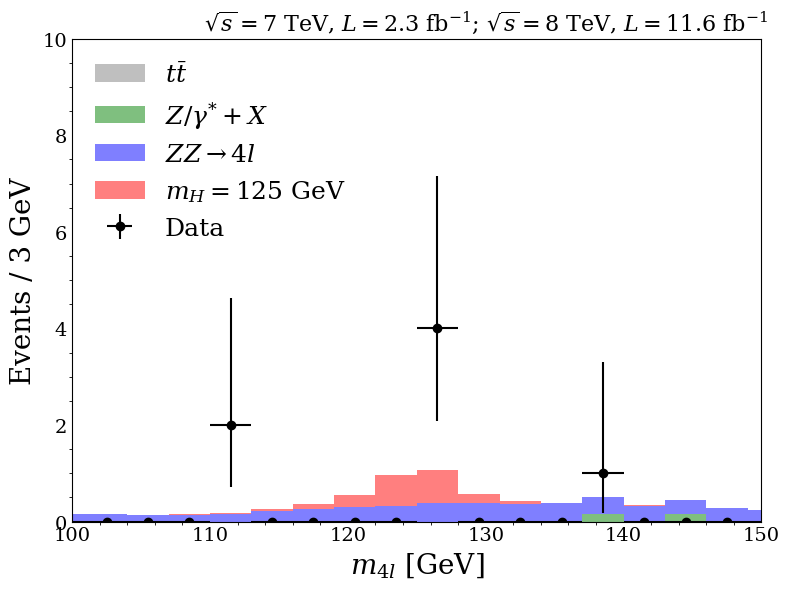

In [78]:
cut_bdt = ' PassBdt == True & PassSel == True & event_type == 2 '

mc_higgs = [mc_higgs_11.query(cut_bdt), mc_higgs_12.query(cut_bdt)]
mc_zz = [mc_zz4mu_11.query(cut_bdt), mc_zz2mu2e_11.query(cut_bdt), mc_zz4e_11.query(cut_bdt), mc_zz4mu_12.query(cut_bdt), mc_zz2mu2e_12.query(cut_bdt), mc_zz4e_12.query(cut_bdt)]
mc_dy = [mc_dy10_11.query(cut_bdt), mc_dy50_11.query(cut_bdt), mc_dy10_12.query(cut_bdt), mc_dy50_12.query(cut_bdt)]
mc_tt = [mc_ttbar_11.query(cut_bdt), mc_ttbar_12.query(cut_bdt)]

rmin = 50
rmax = 200
nbins = 50

 
hist_higgs = HistInvMass4l(mc_higgs,scales_higgs,rmin, rmax, nbins)
hist_zz = HistInvMass4l(mc_zz,scales_zz,rmin, rmax, nbins)
hist_dy= HistInvMass4l(mc_dy,scales_dy,rmin, rmax, nbins)
hist_tt= HistInvMass4l(mc_tt,scales_tt,rmin, rmax, nbins)

hist_mc = [hist_tt, hist_dy, hist_zz, hist_higgs]


## data
inM_data = InvMass_4l(data_evt_sel.query(cut_bdt))
hist, bins = np.histogram(inM_data, bins = nbins, range = (rmin,rmax))
binwidth = bins[1] - bins[0]
bincenter = 0.5 * (bins[:-1] + bins[1:]) 


mask = np.where((119 < bincenter) & (bincenter < 131) )
bincenter[mask]
print("b expected: ", np.sum(hist_zz[mask]) + np.sum(hist_dy[mask]) + np.sum(hist_tt[mask]))
print("s expected: ", np.sum(hist_higgs[mask]))
print("s+b observed: ", np.sum(hist[mask]))


## Now Plot it!!!

plt.figure(figsize = (8,6))
for i,pro in enumerate(hist_mc):
    if i == 0:
        stack = plt.bar(bincenter, pro, align = 'center', width = binwidth, color = colors[3-i], label=labels[3-i],
                 alpha = 0.5)
        bot = pro
    else:
        stack = plt.bar(bincenter, pro, align = 'center', width = binwidth, color = colors[3-i], label=labels[3-i],
                 bottom = bot, alpha = 0.5)
        bot = bot + pro



## Measured data
xerrs = [binwidth*0.5 for i in range(0, nbins)]
yerrs = np.array(get_asymmetrical_uncertainties(hist))
marker_data = plt.errorbar(bincenter, hist, xerr = xerrs, yerr = yerrs, linestyle = 'None', color = 'black',
                        marker = 'o', label = r'Data')



plt.title(r'$ \sqrt{s} = 7$ TeV, $L = 2.3$ fb$^{-1}$; $\sqrt{s} = 8$ TeV, $L = 11.6$ fb$^{-1}$', fontsize = 16, position=(0.6,0.95))
plt.xlabel(r'$m_{4l}$ [GeV]',fontsize = 20, position=(0.92,0.1))
plt.ylabel(r'Events / 3 GeV',fontsize = 20, position=(0.1,0.84))
plt.xlim(100,150)
plt.ylim(0,10)
plt.legend(fontsize = 18, loc = 'upper left', frameon = False)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.minorticks_on()
plt.tight_layout()
plt.savefig("4e.pdf")
plt.show()

b expected:  2.583393400865576
s expected:  3.345316606885286
s+b observed:  6


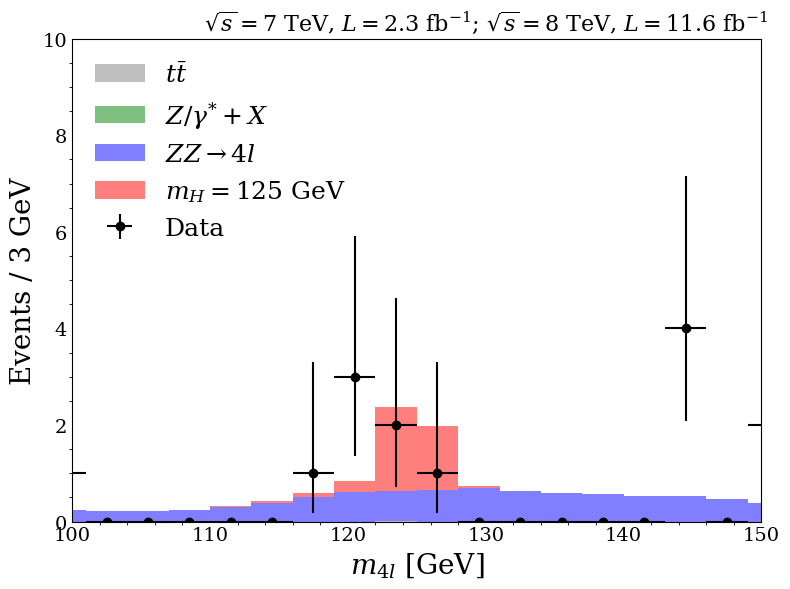

In [79]:
cut_bdt = ' PassBdt == True & PassSel == True & event_type == 3'

mc_higgs = [mc_higgs_11.query(cut_bdt), mc_higgs_12.query(cut_bdt)]
mc_zz = [mc_zz4mu_11.query(cut_bdt), mc_zz2mu2e_11.query(cut_bdt), mc_zz4e_11.query(cut_bdt), mc_zz4mu_12.query(cut_bdt), mc_zz2mu2e_12.query(cut_bdt), mc_zz4e_12.query(cut_bdt)]
mc_dy = [mc_dy10_11.query(cut_bdt), mc_dy50_11.query(cut_bdt), mc_dy10_12.query(cut_bdt), mc_dy50_12.query(cut_bdt)]
mc_tt = [mc_ttbar_11.query(cut_bdt), mc_ttbar_12.query(cut_bdt)]

rmin = 50
rmax = 200
nbins = 50

 
hist_higgs = HistInvMass4l(mc_higgs,scales_higgs,rmin, rmax, nbins)
hist_zz = HistInvMass4l(mc_zz,scales_zz,rmin, rmax, nbins)
hist_dy= HistInvMass4l(mc_dy,scales_dy,rmin, rmax, nbins)
hist_tt= HistInvMass4l(mc_tt,scales_tt,rmin, rmax, nbins)

hist_mc = [hist_tt, hist_dy, hist_zz, hist_higgs]


## data
inM_data = InvMass_4l(data_evt_sel.query(cut_bdt))
hist, bins = np.histogram(inM_data, bins = nbins, range = (rmin,rmax))
binwidth = bins[1] - bins[0]
bincenter = 0.5 * (bins[:-1] + bins[1:]) 


mask = np.where((119 < bincenter) & (bincenter < 131) )
bincenter[mask]
print("b expected: ", np.sum(hist_zz[mask]) + np.sum(hist_dy[mask]) + np.sum(hist_tt[mask]))
print("s expected: ", np.sum(hist_higgs[mask]))
print("s+b observed: ", np.sum(hist[mask]))


## Now Plot it!!!

plt.figure(figsize = (8,6))
for i,pro in enumerate(hist_mc):
    if i == 0:
        stack = plt.bar(bincenter, pro, align = 'center', width = binwidth, color = colors[3-i], label=labels[3-i],
                 alpha = 0.5)
        bot = pro
    else:
        stack = plt.bar(bincenter, pro, align = 'center', width = binwidth, color = colors[3-i], label=labels[3-i],
                 bottom = bot, alpha = 0.5)
        bot = bot + pro



## Measured data
xerrs = [binwidth*0.5 for i in range(0, nbins)]
yerrs = np.array(get_asymmetrical_uncertainties(hist))
marker_data = plt.errorbar(bincenter, hist, xerr = xerrs, yerr = yerrs, linestyle = 'None', color = 'black',
                        marker = 'o', label = r'Data')



plt.title(r'$ \sqrt{s} = 7$ TeV, $L = 2.3$ fb$^{-1}$; $\sqrt{s} = 8$ TeV, $L = 11.6$ fb$^{-1}$', fontsize = 16, position=(0.6,0.95))
plt.xlabel(r'$m_{4l}$ [GeV]',fontsize = 20, position=(0.92,0.1))
plt.ylabel(r'Events / 3 GeV',fontsize = 20, position=(0.1,0.84))
plt.xlim(100,150)
plt.ylim(0,10)
plt.legend(fontsize = 18, loc = 'upper left', frameon = False)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.minorticks_on()
plt.tight_layout()
plt.savefig("4mu.pdf")
plt.show()

In [ ]:
import math
import pylorentz

def compute_boost(df):
    
    p = { }

    for i in range(1,5):
        p[f'{i}'] = pylorentz.Momentum4(df[f"E{i}"], df[f"px{i}"], df[f"py{i}"], df[f"pz{i}"])

    parent = p['1'] + p['2'] + p['3'] + p['4']

    for i in range(1,5):
        p[f'{i}'] = p[f'{i}'].boost(parent.p_x, parent.p_y, parent.p_z, beta=parent.p/parent.e)

    return p

def compute_ang_vars(df):
    p = compute_boost(df)

    cos_theta12 = np.cos( (p['1']+p['2']).theta ) 

    cos_dtheta12 = ( np.sin(p['1'].theta)*np.sin(p['2'].theta)*np.cos(p['1'].phi - p['2'].phi) 
                 + np.cos(p['1'].theta)*np.cos(p['2'].theta) )
    df['cos_theta12'] = cos_theta12
    df['cos_dtheta12'] = cos_dtheta12
    return df

compute_ang_vars(data)
for mc in mc_list:
    compute_ang_vars(mc)    

KeyError: 'cos_theta12'

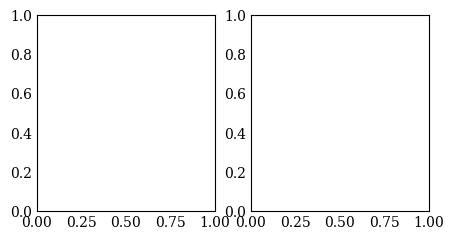

In [57]:
bins2d = (np.arange(-1,1,0.05), np.arange(-1,1,0.05))

fig, (ax1,ax2) = plt.subplots(1,2, figsize = (4,2))

ax1.hist2d(mc_sig['cos_theta12'], mc_sig['cos_dtheta12'], bins2d)
ax2.hist2d(mc_bkg_zz['cos_theta12'], mc_bkg_zz['cos_dtheta12'], bins2d)

fig.show

In [46]:
def make_normalized_hist2d(x, y, bins):
    """
    Build a normalized 2D histogram and return its edges.
    """
    H, xedges, yedges = np.histogram2d(x, y, bins=bins, density=True)
    return H, xedges, yedges

def likelihood_ratio(df, H_sig, H_bkg, xedges, yedges,
                     xcol='cos_theta12', ycol='cos_dtheta12'):
    xvals = df[xcol].to_numpy()
    yvals = df[ycol].to_numpy()

    ix = np.searchsorted(xedges, xvals) - 1
    iy = np.searchsorted(yedges, yvals) - 1

    # Mask out-of-range points
    valid = (
        (ix >= 0) & (ix < H_sig.shape[0]) &
        (iy >= 0) & (iy < H_sig.shape[1])
    )

    lr = np.full_like(xvals, np.nan, dtype=float)

    # For valid points, compute likelihood ratio
    sig_vals = H_sig[ix[valid], iy[valid]]
    bkg_vals = H_bkg[ix[valid], iy[valid]]

    # Avoid division by zero
    ratio = np.divide(sig_vals, bkg_vals, out=np.zeros_like(sig_vals), where=bkg_vals>0)
    lr[valid] = ratio

    df["K_D"] = lr

    return 


bins2d = (np.arange(-1.05, 1.05, 0.1), np.arange(-1.05, 1.05, 0.1))

    # Build normalized histograms
H_sig, xedges, yedges = make_normalized_hist2d(
        mc_sig['cos_theta12'], mc_sig['cos_dtheta12'], bins2d)
H_bkg, _, _ = make_normalized_hist2d(
        mc_bkg_zz['cos_theta12'], mc_bkg_zz['cos_dtheta12'], bins2d)

likelihood_ratio(data, H_sig, H_bkg, xedges, yedges,
                     xcol='cos_theta12', ycol='cos_dtheta12')

for mc in mc_list:
    likelihood_ratio(mc, H_sig, H_bkg, xedges, yedges,
                     xcol='cos_theta12', ycol='cos_dtheta12')

KeyError: 'cos_theta12'

In [47]:
cut_bdt = 'PassSel == True & K_D > 0.5'

mc_higgs = [mc_higgs_11.query(cut_bdt), mc_higgs_12.query(cut_bdt)]
mc_zz = [mc_zz4mu_11.query(cut_bdt), mc_zz2mu2e_11.query(cut_bdt), mc_zz4e_11.query(cut_bdt), mc_zz4mu_12.query(cut_bdt), mc_zz2mu2e_12.query(cut_bdt), mc_zz4e_12.query(cut_bdt)]
mc_dy = [mc_dy10_11.query(cut_bdt), mc_dy50_11.query(cut_bdt), mc_dy10_12.query(cut_bdt), mc_dy50_12.query(cut_bdt)]
mc_tt = [mc_ttbar_11.query(cut_bdt), mc_ttbar_12.query(cut_bdt)]

rmin = 50
rmax = 200
nbins = 50

 
hist_higgs = HistInvMass4l(mc_higgs,scales_higgs,rmin, rmax, nbins)
hist_zz = HistInvMass4l(mc_zz,scales_zz,rmin, rmax, nbins)
hist_dy= HistInvMass4l(mc_dy,scales_dy,rmin, rmax, nbins)
hist_tt= HistInvMass4l(mc_tt,scales_tt,rmin, rmax, nbins)

hist_mc = [hist_tt, hist_dy, hist_zz, hist_higgs]


## data
inM_data = InvMass_4l(data_evt_sel.query(cut_bdt))
hist, bins = np.histogram(inM_data, bins = nbins, range = (rmin,rmax))
binwidth = bins[1] - bins[0]
bincenter = 0.5 * (bins[:-1] + bins[1:]) 


mask = np.where((119 < bincenter) & (bincenter < 131) )
bincenter[mask]
print("b expected: ", np.sum(hist_zz[mask]) + np.sum(hist_dy[mask]) + np.sum(hist_tt[mask]))
print("s expected: ", np.sum(hist_higgs[mask]))
print("expected excess:", np.sum(hist_higgs[mask])/np.sqrt(np.sum(hist_zz[mask]) + np.sum(hist_dy[mask]) + np.sum(hist_tt[mask]))) 
print("s+b observed: ", np.sum(hist[mask]))


## Now Plot it!!!

plt.figure(figsize = (8,6))
for i,pro in enumerate(hist_mc):
    if i == 0:
        stack = plt.bar(bincenter, pro, align = 'center', width = binwidth, color = colors[3-i], label=labels[3-i],
                 alpha = 0.5)
        bot = pro
    else:
        stack = plt.bar(bincenter, pro, align = 'center', width = binwidth, color = colors[3-i], label=labels[3-i],
                 bottom = bot, alpha = 0.5)
        bot = bot + pro



## Measured data
xerrs = [binwidth*0.5 for i in range(0, nbins)]
yerrs = np.array(get_asymmetrical_uncertainties(hist))
marker_data = plt.errorbar(bincenter, hist, xerr = xerrs, yerr = yerrs, linestyle = 'None', color = 'black',
                        marker = 'o', label = r'Data')



plt.title(r'$ \sqrt{s} = 7$ TeV, $L = 2.3$ fb$^{-1}$; $\sqrt{s} = 8$ TeV, $ L = 11.6$ fb$^{-1}$', fontsize = 16, position=(0.6,0.95))
plt.xlabel(r'$m_{4l}$ [GeV]',fontsize = 20, position=(0.92,0.1))
plt.ylabel(r'Events / 3 GeV',fontsize = 20, position=(0.1,0.84))
plt.xlim(60,180)
plt.ylim(0,20)
plt.legend(fontsize = 18, loc = 'upper right', frameon = False)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.annotate(r"$K_D>0.5$", xy = (0.7,0.5), xycoords="axes fraction" , fontsize = 18)
plt.minorticks_on()
plt.tight_layout()
plt.savefig("K_D.pdf")
plt.show()

UndefinedVariableError: name 'K_D' is not defined